### libraries

In [2]:
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes
from matplotlib.lines import Line2D
from imblearn.combine import SMOTEENN

In [3]:
# Import libraries for LR
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [4]:
from sklearn import tree          
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics
# Import libraries 
from sklearn import tree          
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
# Import libraries
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import graphviz  

In [5]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [6]:
from xgboost import XGBClassifier

# Helper functions for model training

In [7]:
# function that returns dataset with propensity scores and propensity logits from logistic regression
def propensity_score_funct(dataset,model):
    # Generate propensity score prediction 
    probabilities = model.predict_proba(dataset.drop('treat', axis=1))
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1] # propensity score 
    # merge prediction and existing dataset 
    dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    
    #dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    dataset_proba['propensity_logit'] = pd.DataFrame(np.nan_to_num(np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score'])),posinf=0,neginf=0))
    


In [8]:
resample=SMOTEENN(random_state=0)
# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
	
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

# 1 - Load data sets 

In [9]:
'''
Load all datasets.
nsw = Male sub sample of treated and control units as used by Lalonde (1986).
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

cps1 = full Current Population Survey dataset
cps2 , cps3 and cps4 are further subsamples exctracted by lalonde to with distributions which better match the nsw treated group.

psid1 = full Panel Study of Income Dynamics dataset
psid2,psid3,psid4 are again subsamples extracted by Lalonde 

'''
# experimental data 

nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_treated.xlsx')
nswre74 = pd.concat([nswre74_control,nswre74_treated],axis=0,ignore_index=True) #Combine treatment into a single control as pandas dataframe

# non experimental data (cps)

cps = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/cps_controls.dta")
cps.drop('data_id', axis=1, inplace=True)

#cps['treat'] == 0 # created treated column
#load non experimental data (psid)

psid = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/psid_controls.dta")
psid.drop('data_id', axis=1, inplace=True)

# reset indexes

nsw = nsw.reset_index(drop=True)
nswre74 = nswre74.reset_index(drop=True)
cps = cps.reset_index(drop=True)
psid = psid.reset_index(drop=True)

# PS estimation helper functions

In [17]:
def propensity_score_funct(dataset,model,dataset2,dehwab):
    
    dataset2.columns = dataset2.columns.str.strip() 
    
    if dehwab == True: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]

    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1]  # propensity score 

    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [18]:
resample=SMOTEENN(random_state=0)
# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
	

	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

# 2. Propensity score estimation

In [54]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

### PS specs

In [55]:
ps_specification_logit_1 = ['treat','education*','black','hispanic','married','married_u75','nodegree','re75']
ps_specification_logit_2 = ['treat','age','education*','black','married','hispanic','black_education','hisp_re75','nodegree','re75']
ps_specification_logit_3 = ['treat','age','education*','black','hispanic','nodegree','black_age','married','re74','re75']
ps_specification_logit_4 = ['treat','age','education*','black','married','hispanic','married_u75','nodegree','re74','re75']



In [56]:
#['treat','age','education*','black','married','nodegree','re75'] # CPS Lalonde sample 
markov_blanket_specification_1 = ['treat','age','black','education*','married','nodegree','re75'] # CPS Lalonde sample 
markov_blanket_specification_2 = ['treat','age','black','education*','married','nodegree','re75']  # PSID Lalonde sample 
markov_blanket_specification_3 = ['treat','age','black','education*','married','nodegree','re74','re75'] # CPS Dehwab sample
markov_blanket_specification_4 = ['treat','age','black','education*','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 

In [57]:
annSpecification_1 = ['treat','ageboxcox','black','education*','married','nodegree','re75'] # CPS Lalonde sample 
annSpecification_2 = ['treat','ageboxcox','black','education*','married','nodegree','re75']# PSID Lalonde sample  
annSpecification_3 = ['treat','ageboxcox','black','education*','married','nodegree','re74','re75'] # CPS Dehwab sample
annSpecification_4 = ['treat','ageboxcox','black','education*','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 
nsw_continuos_vars1 = ['ageboxcox','re75'] 
nsw_continuos_vars2 = ['ageboxcox','re75'] 
nswre74_continuos_vars1 = ['ageboxcox','re75',] 
nswre74_continuos_vars2 = ['ageboxcox','re74','re75',] 

### model (1) Logistic Regression 

### Data

In [58]:
# Select covariates for use in Logit model 

# ======== Lalonde (1986) data ======== #

nswCps_lalonde_subset = nswCps_lalonde[ps_specification_logit_1]
nswPsid_lalonde_subset = nswPsid_lalonde[ps_specification_logit_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

nswCps_dehWab_subset = nswCps_dehWab[ps_specification_logit_3]
nswPsid_dehWab_subset = nswPsid_dehWab[ps_specification_logit_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

### Validation

In [59]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
		

	#Kfold training loop
	
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


In [60]:
from sklearn.linear_model import LogisticRegression
# dataframes to store resutls 
logit1_metrics = pd.DataFrame()
logit2_metrics = pd.DataFrame()
logit3_metrics = pd.DataFrame()
logit4_metrics = pd.DataFrame()
#models 
logit1 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit2 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit3 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit4 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)


In [61]:
# Model validation - K fold 
# ======== Lalonde (1986) sample ======== #
kfold_evaluation(logit1,nswCps_lalonde_features,nswCps_lalonde_target,logit1_metrics) # cps
kfold_evaluation(logit2,nswPsid_lalonde_features,nswPsid_lalonde_target,logit2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation(logit3,nswCps_dehWab_features,nswCps_dehWab_target,logit3_metrics) # cps
kfold_evaluation(logit4,nswPsid_dehWab_features,nswPsid_dehWab_target,logit4_metrics) # psid

In [62]:
logit1_metrics['avg'] = np.mean(logit1_metrics,axis=1)
logit2_metrics['avg'] = np.mean(logit2_metrics,axis=1)
logit3_metrics['avg'] = np.mean(logit3_metrics,axis=1)
logit4_metrics['avg'] = np.mean(logit4_metrics,axis=1)

In [63]:
logit1_metrics

,0,1,2,3,4,avg
Accuracy:,0.888868,0.864759,0.861991,0.900891,0.892650,0.881832
Precision:,0.121348,0.130890,0.112360,0.129496,0.096552,0.118129
Recall:,0.900000,0.833333,0.847458,0.915254,0.949153,0.889040
MSE:,0.121854,0.104972,0.124002,0.112953,0.161805,0.125117
MAE:,0.121854,0.104972,0.124002,0.112953,0.161805,0.125117
R^2:,-5.740807,-4.806942,-5.973747,-5.352324,-8.096994,-5.994163
auc:,0.888868,0.864759,0.861991,0.900891,0.892650,0.881832
roc_auc:,0.962044,0.947871,0.945158,0.959619,0.964756,0.955889
F1:,0.213861,0.226244,0.198413,0.226891,0.175274,0.208137
log-loss:,0.263571,0.241323,0.262708,0.270125,0.337827,0.275111


In [64]:
logit1.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [65]:
logit2_metrics

,0,1,2,3,4,avg
Accuracy:,0.869779,0.913855,0.862603,0.904976,0.917790,0.893801
Precision:,0.481132,0.600000,0.521739,0.546392,0.467213,0.523295
Recall:,0.850000,0.900000,0.813559,0.898305,0.966102,0.885593
MSE:,0.114695,0.075269,0.098743,0.089767,0.120287,0.099752
MAE:,0.114695,0.075269,0.098743,0.089767,0.120287,0.099752
R^2:,-0.195181,0.215663,-0.042645,0.052141,-0.270131,-0.048031
auc:,0.869779,0.913855,0.862603,0.904976,0.917790,0.893801
roc_auc:,0.960793,0.972122,0.951603,0.972262,0.974032,0.966162
F1:,0.614458,0.720000,0.635762,0.679487,0.629834,0.655908
log-loss:,0.250577,0.200025,0.241414,0.204177,0.283941,0.236027


In [66]:
logit2.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [67]:
logit3_metrics

,0,1,2,3,4,avg
Accuracy:,0.879603,0.878040,0.875767,0.893413,0.936143,0.892593
Precision:,0.086486,0.084211,0.100977,0.089431,0.100559,0.092333
Recall:,0.864865,0.864865,0.837838,0.891892,0.972973,0.886486
MSE:,0.105995,0.109085,0.087172,0.105100,0.099845,0.101440
MAE:,0.105995,0.109085,0.087172,0.105100,0.099845,0.101440
R^2:,-8.377491,-8.650888,-6.709802,-8.295506,-7.830730,-7.972883
auc:,0.879603,0.878040,0.875767,0.893413,0.936143,0.892593
roc_auc:,0.961863,0.948616,0.969677,0.953949,0.983055,0.963432
F1:,0.157248,0.153477,0.180233,0.162562,0.182278,0.167160
log-loss:,0.233103,0.260611,0.213819,0.247897,0.239693,0.239025


In [68]:
logit3.get_params

<bound method BaseEstimator.get_params of LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)>

In [69]:
logit4_metrics

,0,1,2,3,4,avg
Accuracy:,0.942310,0.897292,0.957831,0.885244,0.957831,0.928102
Precision:,0.450000,0.477612,0.468354,0.405063,0.468354,0.453877
Recall:,0.972973,0.864865,1.000000,0.864865,1.000000,0.940541
MSE:,0.084112,0.074766,0.078505,0.097196,0.078505,0.082617
MAE:,0.084112,0.074766,0.078505,0.097196,0.078505,0.082617
R^2:,-0.306578,-0.161402,-0.219472,-0.509823,-0.219472,-0.283350
auc:,0.942310,0.897292,0.957831,0.885244,0.957831,0.928102
roc_auc:,0.983122,0.962254,0.982036,0.949256,0.986215,0.972577
F1:,0.615385,0.615385,0.637931,0.551724,0.637931,0.611671
log-loss:,0.192810,0.177873,0.200565,0.260109,0.206918,0.207655


In [70]:
logit4.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Inference

In [71]:
# Fit Logistic Regression using sklearn
# ======== Lalonde (1986) sample ======== #
logit1.fit(nswCps_lalonde_features,nswCps_lalonde_target) # cps
logit2.fit(nswPsid_lalonde_features,nswPsid_lalonde_target) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
logit3.fit(nswCps_dehWab_features,nswCps_dehWab_target) # cps
logit4.fit(nswPsid_dehWab_features,nswPsid_dehWab_target) # psid

LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)

In [72]:
# Change logisistic regression to STAT's model implementation 

In [73]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
nswCps_lalonde_ps_LOGIT_withRe78 = propensity_score_funct(nswCps_lalonde_subset,logit1,nswCps_lalonde,False)
nswPsid_lalonde_ps_LOGIT_withRe78= propensity_score_funct(nswPsid_lalonde_subset,logit2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_LOGIT_withRe78 = propensity_score_funct(nswCps_dehWab_subset,logit3,nswCps_dehWab,True)
nswPsid_dehWab_ps_LOGIT_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,logit4,nswPsid_dehWab,True)


# Export data

In [74]:
# save unmatched logit datasets 
nswCps_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswCps_lalonde_ps_unmatched_LOGIT_FS1.csv')
nswPsid_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswPsid_lalonde_ps_unmatched_LOGIT_FS1.csv')
nswCps_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswCps_dehWab_ps_unmatched_LOGIT_FS1.csv')
nswPsid_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswPsid_dehWab_ps_unmatched_LOGIT_FS1.csv')

### model (2) ; CART 

In [75]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

# CART - Feature selection

In [76]:
""" Select covariates for use in CART model - from GNN features """
# ======== Lalonde (1986) data ======== #
nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection

nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)


## Validation 

In [77]:
# Grid search 
tree_param = [{'criterion': ['entropy', 'gini'], 
               'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
               'max_leaf_nodes':list(range(0, 100)),
              'min_samples_leaf': [2, 3, 4]}]



In [78]:
cart1_metrics = pd.DataFrame()
cart2_metrics = pd.DataFrame()
cart3_metrics = pd.DataFrame()
cart4_metrics = pd.DataFrame()

grid_search_cart1 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 12,min_samples_leaf = 2)
grid_search_cart2 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 7,max_leaf_nodes = 10,min_samples_leaf = 2)
grid_search_cart3 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 10,min_samples_leaf = 2)
grid_search_cart4 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 10,min_samples_leaf = 2)

In [79]:
kfold_evaluation_SMOTEENN(grid_search_cart1,nswCps_lalonde_features,nswCps_lalonde_target,cart1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart2,nswPsid_lalonde_features,nswPsid_lalonde_target,cart2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_cart3,nswCps_dehWab_features,nswCps_dehWab_target,cart3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart4,nswPsid_dehWab_features,nswPsid_dehWab_target,cart4_metrics) # psid

<p> model evaluation </p>

In [80]:
cart1_metrics['avg'] = np.mean(cart1_metrics,axis=1)
cart2_metrics['avg'] = np.mean(cart2_metrics,axis=1)
cart3_metrics['avg'] = np.mean(cart3_metrics,axis=1)
cart4_metrics['avg'] = np.mean(cart4_metrics,axis=1)

In [81]:
cart1_metrics

,0,1,2,3,4,avg
Accuracy:,0.828377,0.844575,0.811093,0.855063,0.861876,0.840197
Precision:,0.325397,0.328244,0.351852,0.278481,0.167857,0.290366
Recall:,0.683333,0.716667,0.644068,0.745763,0.796610,0.717288
MSE:,0.031921,0.032228,0.027931,0.039595,0.075223,0.041380
MAE:,0.031921,0.032228,0.027931,0.039595,0.075223,0.041380
R^2:,-0.765854,-0.782833,-0.570819,-1.226766,-3.229153,-1.315085
auc:,0.828377,0.844575,0.811093,0.855063,0.861876,0.840197
roc_auc:,0.912344,0.904073,0.934929,0.952414,0.950856,0.930923
F1:,0.440860,0.450262,0.455090,0.405530,0.277286,0.405806
log-loss:,0.203878,0.153560,0.163919,0.171362,0.270913,0.192726


In [82]:
cart2_metrics

,0,1,2,3,4,avg
Accuracy:,0.834839,0.893273,0.856698,0.931965,0.925379,0.888431
Precision:,0.529412,0.765625,0.582278,0.617978,0.533333,0.605725
Recall:,0.750000,0.816667,0.779661,0.932203,0.949153,0.845537
MSE:,0.098566,0.046595,0.082585,0.068223,0.093357,0.077865
MAE:,0.098566,0.046595,0.082585,0.068223,0.093357,0.077865
R^2:,-0.027108,0.514458,0.127970,0.279627,0.014226,0.181834
auc:,0.834839,0.893273,0.856698,0.931965,0.925379,0.888431
roc_auc:,0.900770,0.938454,0.926758,0.951858,0.958614,0.935291
F1:,0.620690,0.790323,0.666667,0.743243,0.682927,0.700770
log-loss:,0.591625,0.288754,0.370685,0.200968,0.303993,0.351205


In [83]:
cart3_metrics

,0,1,2,3,4,avg
Accuracy:,0.907040,0.883055,0.891490,0.894305,0.922270,0.899632
Precision:,0.289720,0.173410,0.252101,0.297030,0.329897,0.268431
Recall:,0.837838,0.810811,0.810811,0.810811,0.864865,0.827027
MSE:,0.025340,0.046354,0.029675,0.024111,0.021638,0.029424
MAE:,0.025340,0.046354,0.029675,0.024111,0.021638,0.029424
R^2:,-1.241849,-3.100944,-1.624613,-1.132498,-0.913781,-1.602737
auc:,0.907040,0.883055,0.891490,0.894305,0.922270,0.899632
roc_auc:,0.946613,0.921542,0.908499,0.974351,0.974059,0.945013
F1:,0.430556,0.285714,0.384615,0.434783,0.477612,0.402656
log-loss:,0.107183,0.154493,0.116569,0.138555,0.106300,0.124620


In [84]:
cart4_metrics

,0,1,2,3,4,avg
Accuracy:,0.925866,0.911348,0.926870,0.885325,0.984940,0.926870
Precision:,0.622642,0.603774,0.634615,0.600000,0.711538,0.634514
Recall:,0.891892,0.864865,0.891892,0.810811,1.000000,0.891892
MSE:,0.044860,0.048598,0.042991,0.050467,0.028037,0.042991
MAE:,0.044860,0.048598,0.042991,0.050467,0.028037,0.042991
R^2:,0.303159,0.245088,0.332194,0.216053,0.564474,0.332194
auc:,0.925866,0.911348,0.926870,0.885325,0.984940,0.926870
roc_auc:,0.977206,0.949962,0.922148,0.872816,0.984397,0.941306
F1:,0.733333,0.711111,0.741573,0.689655,0.831461,0.741427
log-loss:,0.197019,0.282188,0.494316,0.674606,0.351292,0.399884


### Inference

In [85]:
nswCps_lalonde_ps_CART_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_cart1,nswCps_lalonde,False)
nswPsid_lalonde_ps_CART_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_cart2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_CART_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_cart3,nswCps_dehWab,True)
nswPsid_dehWab_ps_CART_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_cart4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [86]:
nswCps_dehWab_ps_CART_withRe78

,treat,age,education*,black,hispanic,married,nodegree,re74,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,0,9930,0.909524,2.307834
1,1.0,22,9,0.0,1.0,0.0,1.0,0,0,3595,0.075630,-2.503256
2,1.0,30,12,1.0,0.0,0.0,0.0,0,0,24909,0.997093,5.837598
3,1.0,27,11,1.0,0.0,0.0,1.0,0,0,7506,0.997093,5.837598
4,1.0,33,8,1.0,0.0,0.0,1.0,0,0,289,0.997093,5.837598
...,...,...,...,...,...,...,...,...,...,...,...,...
16172,0.0,22,12,1.0,0.0,0.0,0.0,3975,6801,2757,0.973103,3.588482
16173,0.0,20,12,1.0,0.0,1.0,0.0,1445,11832,6895,0.204762,-1.356794
16174,0.0,37,12,0.0,0.0,0.0,0.0,1733,1559,4221,0.075630,-2.503256
16175,0.0,47,9,0.0,0.0,1.0,1.0,16914,11384,13671,0.000000,-inf


In [44]:
# save unmatched CART datasets 
nswCps_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswCps_lalonde_ps_unmatched_CART_FS1.csv')
nswPsid_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswPsid_lalonde_ps_unmatched_CART_FS1.csv')
nswCps_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswCps_dehWab_ps_unmatched_CART_FS1.csv')
nswPsid_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswPsid_dehWab_ps_unmatched_CART_FS1.csv')

### model (3) ; Random Forest

In [87]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78


In [88]:
""" Select covariates for use in CART model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #

nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

## Validation 

In [89]:
forest1_metrics = pd.DataFrame()
forest2_metrics = pd.DataFrame()
forest3_metrics = pd.DataFrame()
forest4_metrics = pd.DataFrame()

grid_search_forest1 = RandomForestClassifier(random_state=0,criterion = 'entropy',max_depth = 8,max_features = 'sqrt',min_samples_split = 2,n_estimators= 100)
grid_search_forest2 = RandomForestClassifier(random_state=0,criterion = 'gini',max_depth = 8,max_features = 'sqrt',min_samples_split = 2,n_estimators= 100)
grid_search_forest3 = RandomForestClassifier(random_state=0,criterion = 'entropy',max_depth = 8,max_features = 'log2',min_samples_split = 3,n_estimators= 500)
grid_search_forest4 = RandomForestClassifier(random_state=0,criterion = 'gini',max_depth = 8,max_features = 'log2',min_samples_leaf = 2,n_estimators= 500)

In [90]:
kfold_evaluation_SMOTEENN(grid_search_forest1,nswCps_lalonde_features,nswCps_lalonde_target,forest1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest2,nswPsid_lalonde_features,nswPsid_lalonde_target,forest2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_forest3,nswCps_dehWab_features,nswCps_dehWab_target,forest3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest4,nswPsid_dehWab_features,nswPsid_dehWab_target,forest4_metrics) # psid

In [91]:
forest1_metrics['avg'] = np.mean(forest1_metrics,axis=1)
forest2_metrics['avg'] = np.mean(forest2_metrics,axis=1)
forest3_metrics['avg'] = np.mean(forest3_metrics,axis=1)
forest4_metrics['avg'] = np.mean(forest4_metrics,axis=1)

In [92]:
forest1_metrics

,0,1,2,3,4,avg
Accuracy:,0.840353,0.847702,0.821321,0.866039,0.920040,0.859091
Precision:,0.272152,0.387387,0.261438,0.314685,0.282609,0.303654
Recall:,0.716667,0.716667,0.677966,0.762712,0.881356,0.751073
MSE:,0.040516,0.026090,0.040516,0.034377,0.042677,0.036835
MAE:,0.040516,0.026090,0.040516,0.034377,0.042677,0.036835
R^2:,-1.241276,-0.443246,-1.278551,-0.933316,-1.399397,-1.059157
auc:,0.840353,0.847702,0.821321,0.866039,0.920040,0.859091
roc_auc:,0.952116,0.952283,0.933788,0.969426,0.979028,0.957328
F1:,0.394495,0.502924,0.377358,0.445545,0.427984,0.429661
log-loss:,0.108171,0.101750,0.132206,0.112388,0.123123,0.115528


In [93]:
forest2_metrics


,0,1,2,3,4,avg
Accuracy:,0.853916,0.902610,0.861718,0.899632,0.922487,0.888073
Precision:,0.681818,0.781250,0.621622,0.675676,0.606742,0.673421
Recall:,0.750000,0.833333,0.779661,0.847458,0.915254,0.825141
MSE:,0.064516,0.043011,0.073609,0.059246,0.071813,0.062439
MAE:,0.064516,0.043011,0.073609,0.059246,0.071813,0.062439
R^2:,0.327711,0.551807,0.222755,0.374413,0.241713,0.343680
auc:,0.853916,0.902610,0.861718,0.899632,0.922487,0.888073
roc_auc:,0.948226,0.965579,0.942397,0.972670,0.974985,0.960771
F1:,0.714286,0.806452,0.691729,0.751880,0.729730,0.738815
log-loss:,0.248893,0.192682,0.297293,0.152692,0.200341,0.218380


In [94]:
forest3_metrics

,0,1,2,3,4,avg
Accuracy:,0.885640,0.896184,0.859080,0.898995,0.885013,0.884982
Precision:,0.420290,0.337079,0.421875,0.422535,0.397260,0.399808
Recall:,0.783784,0.810811,0.729730,0.810811,0.783784,0.783784
MSE:,0.014833,0.020396,0.014529,0.014838,0.016074,0.016134
MAE:,0.014833,0.020396,0.014529,0.014838,0.016074,0.016134
R^2:,-0.312302,-0.804415,-0.284967,-0.312307,-0.421666,-0.427131
auc:,0.885640,0.896184,0.859080,0.898995,0.885013,0.884982
roc_auc:,0.981240,0.955480,0.986799,0.954816,0.989056,0.973478
F1:,0.547170,0.476190,0.534653,0.555556,0.527273,0.528168
log-loss:,0.054616,0.078579,0.046260,0.064213,0.055769,0.059887


In [95]:
forest4_metrics

,0,1,2,3,4,avg
Accuracy:,0.916368,0.907875,0.913356,0.885325,0.962933,0.917171
Precision:,0.666667,0.738095,0.627451,0.600000,0.777778,0.681998
Recall:,0.864865,0.837838,0.864865,0.810811,0.945946,0.864865
MSE:,0.039252,0.031776,0.044860,0.050467,0.022430,0.037757
MAE:,0.039252,0.031776,0.044860,0.050467,0.022430,0.037757
R^2:,0.390264,0.506404,0.303159,0.216053,0.651579,0.413492
auc:,0.916368,0.907875,0.913356,0.885325,0.962933,0.917171
roc_auc:,0.986107,0.973163,0.988874,0.921660,0.991751,0.972311
F1:,0.752941,0.784810,0.727273,0.689655,0.853659,0.761668
log-loss:,0.092106,0.123182,0.107716,0.318707,0.092587,0.146859


### Inference

In [96]:
#  Lalonde Subsample 
nswCps_lalonde_ps_FOREST_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_forest1,nswCps_lalonde,False)
nswPsid_lalonde_ps_FOREST_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_forest2,nswPsid_lalonde,False)
#  Dehejia & Wahba sub sample 
nswCps_dehWab_ps_FOREST_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3,nswCps_dehWab,True)
nswPsid_dehWab_ps_FOREST_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [97]:
nswCps_dehWab_ps_FOREST_withRe78

,treat,age,education*,black,hispanic,married,nodegree,re74,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,0,9930,0.935999,2.682723
1,1.0,22,9,0.0,1.0,0.0,1.0,0,0,3595,0.351583,-0.612088
2,1.0,30,12,1.0,0.0,0.0,0.0,0,0,24909,0.988211,4.428687
3,1.0,27,11,1.0,0.0,0.0,1.0,0,0,7506,0.996804,5.742562
4,1.0,33,8,1.0,0.0,0.0,1.0,0,0,289,0.996507,5.653493
...,...,...,...,...,...,...,...,...,...,...,...,...
16172,0.0,22,12,1.0,0.0,0.0,0.0,3975,6801,2757,0.624854,0.510203
16173,0.0,20,12,1.0,0.0,1.0,0.0,1445,11832,6895,0.013650,-4.280268
16174,0.0,37,12,0.0,0.0,0.0,0.0,1733,1559,4221,0.029262,-3.501750
16175,0.0,47,9,0.0,0.0,1.0,1.0,16914,11384,13671,0.000000,-inf


In [56]:
# save unmatched logit datasets 
nswCps_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswCps_lalonde_ps_unmatched_FOREST_FS1.csv')
nswPsid_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswPsid_lalonde_ps_unmatched_FOREST_FS1.csv')
nswCps_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswCps_dehWab_ps_unmatched_FOREST_FS1.csv')
nswPsid_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswPsid_dehWab_ps_unmatched_FOREST_FS1.csv')

### model (4) ; Boosted Trees

In [98]:
""" Select covariates for use in BOOST model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



## Validation 

In [99]:
# dataframes to store results 
boost1_metrics = pd.DataFrame()
boost2_metrics = pd.DataFrame()
boost3_metrics = pd.DataFrame()
boost4_metrics = pd.DataFrame()
    

# models 
grid_search_boost1 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'dart',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    max_depth = None,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost2 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'dart',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    max_depth = None,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost3 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'gbtree',
                                    colsample_bytree = 0.3,
                                    gamma = 1,
                                    learning_rate = 0.05,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost4 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'gbtree',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 

In [100]:
kfold_evaluation_SMOTEENN(grid_search_boost1,nswCps_lalonde_features,nswCps_lalonde_target,boost1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost2,nswPsid_lalonde_features,nswPsid_lalonde_target,boost2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_boost3,nswCps_dehWab_features,nswCps_dehWab_target,boost3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost4,nswPsid_dehWab_features,nswPsid_dehWab_target,boost4_metrics) # psid

In [101]:
boost1_metrics['avg'] = np.mean(boost1_metrics,axis=1)
boost2_metrics['avg'] = np.mean(boost2_metrics,axis=1)
boost3_metrics['avg'] = np.mean(boost3_metrics,axis=1)
boost4_metrics['avg'] = np.mean(boost4_metrics,axis=1)

In [102]:
boost1_metrics

,0,1,2,3,4,avg
Accuracy:,0.854503,0.885710,0.837939,0.894535,0.930643,0.880666
Precision:,0.141593,0.201613,0.121693,0.174658,0.166172,0.161146
Recall:,0.800000,0.833333,0.779661,0.864407,0.949153,0.845311
MSE:,0.093002,0.063843,0.105893,0.076427,0.087197,0.085272
MAE:,0.093002,0.063843,0.105893,0.076427,0.087197,0.085272
R^2:,-4.144747,-2.531707,-4.955304,-3.298176,-3.902365,-3.766460
auc:,0.854503,0.885710,0.837939,0.894535,0.930643,0.880666
roc_auc:,0.945708,0.954422,0.939465,0.960425,0.976341,0.955272
F1:,0.240602,0.324675,0.210526,0.290598,0.282828,0.269846
log-loss:,0.220633,0.192769,0.222491,0.210346,0.212000,0.211648


In [103]:
boost2_metrics

,0,1,2,3,4,avg
Accuracy:,0.881526,0.898594,0.863726,0.902083,0.927388,0.894663
Precision:,0.588235,0.735294,0.638889,0.629630,0.543689,0.627147
Recall:,0.833333,0.833333,0.779661,0.864407,0.949153,0.851977
MSE:,0.080645,0.050179,0.070018,0.068223,0.089767,0.071766
MAE:,0.080645,0.050179,0.070018,0.068223,0.089767,0.071766
R^2:,0.159639,0.477108,0.260670,0.279627,0.052141,0.245837
auc:,0.881526,0.898594,0.863726,0.902083,0.927388,0.894663
roc_auc:,0.955773,0.961011,0.949765,0.969880,0.973947,0.962075
F1:,0.689655,0.781250,0.702290,0.728571,0.691358,0.718625
log-loss:,0.221397,0.177949,0.213985,0.194535,0.221135,0.205800


In [104]:
boost3_metrics

,0,1,2,3,4,avg
Accuracy:,0.906259,0.885399,0.881729,0.916485,0.943825,0.906739
Precision:,0.276786,0.189873,0.308511,0.238806,0.253731,0.253541
Recall:,0.837838,0.810811,0.783784,0.864865,0.918919,0.843243
MSE:,0.026885,0.041718,0.022566,0.033076,0.031839,0.031217
MAE:,0.026885,0.041718,0.022566,0.033076,0.031839,0.031217
R^2:,-1.378547,-2.690849,-0.995800,-1.925350,-1.815991,-1.761308
auc:,0.906259,0.885399,0.881729,0.916485,0.943825,0.906739
roc_auc:,0.978317,0.951129,0.982358,0.955707,0.989875,0.971477
F1:,0.416107,0.307692,0.442748,0.374269,0.397661,0.387696
log-loss:,0.088943,0.104351,0.081000,0.100260,0.096278,0.094166


In [105]:
boost4_metrics

,0,1,2,3,4,avg
Accuracy:,0.939379,0.917372,0.936367,0.889802,0.972430,0.931070
Precision:,0.629630,0.680851,0.596491,0.516667,0.720000,0.628728
Recall:,0.918919,0.864865,0.918919,0.837838,0.972973,0.902703
MSE:,0.042991,0.037383,0.048598,0.065421,0.028037,0.044486
MAE:,0.042991,0.037383,0.048598,0.065421,0.028037,0.044486
R^2:,0.332194,0.419299,0.245088,-0.016227,0.564474,0.308966
auc:,0.939379,0.917372,0.936367,0.889802,0.972430,0.931070
roc_auc:,0.987409,0.973244,0.985890,0.943042,0.990096,0.975936
F1:,0.747253,0.761905,0.723404,0.639175,0.827586,0.739865
log-loss:,0.112481,0.122435,0.132912,0.194032,0.112918,0.134956


### Inference

In [65]:
#  Lalonde Subsample 
nswCps_lalonde_ps_BOOST_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_boost1,nswCps_lalonde,False)
nswPsid_lalonde_ps_BOOST_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_boost2,nswPsid_lalonde,False)
#  Dehejia & Wahba sub sample 
nswCps_dehWab_ps_BOOST_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3,nswCps_dehWab,True)
nswPsid_dehWab_ps_BOOST_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [66]:
# save unmatched boost datasets 
nswCps_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswCps_lalonde_ps_unmatched_BOOST_FS1.csv')
nswPsid_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswPsid_lalonde_ps_unmatched_BOOST_FS1.csv')
nswCps_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswCps_dehWab_ps_unmatched_BOOST_FS1.csv')
nswPsid_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswPsid_dehWab_ps_unmatched_BOOST_FS1.csv')

In [67]:
nswPsid_lalonde_ps_BOOST_withRe78

,treat,age,education*,black,hispanic,married,nodegree,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,9930,0.666927,0.694318
1,1.0,22,9,0.0,1.0,0.0,1.0,0,3595,0.795578,1.358880
2,1.0,30,12,1.0,0.0,0.0,0.0,0,24909,0.760319,1.154429
3,1.0,27,11,1.0,0.0,0.0,1.0,0,7506,0.927031,2.541952
4,1.0,33,8,1.0,0.0,0.0,1.0,0,289,0.830640,1.590167
...,...,...,...,...,...,...,...,...,...,...,...
2782,0.0,47,8,0.0,0.0,1.0,1.0,33837,38568,0.028660,-3.523185
2783,0.0,32,8,0.0,0.0,1.0,1.0,67137,59109,0.050490,-2.934166
2784,0.0,47,10,0.0,0.0,1.0,1.0,47968,55710,0.036989,-3.259447
2785,0.0,54,0,0.0,1.0,1.0,1.0,44220,20540,0.018303,-3.982226


### model (5) - artifical neural network

In [10]:
# Import libraries 
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import  DataLoader,SubsetRandomSampler 
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import GridSearchCV
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
import seaborn as sns
from scipy import stats 
from psmpy.functions import cohenD
from psmpy.plotting import *
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN


In [11]:
annSpecification_1 = ['treat','ageboxcox','black','education*','married','nodegree','re75'] # CPS Lalonde sample 
annSpecification_2 = ['treat','ageboxcox','black','education*','married','nodegree','re75']# PSID Lalonde sample  
annSpecification_3 = ['treat','ageboxcox','black','education*','married','nodegree','re74','re75'] # CPS Dehwab sample
annSpecification_4 = ['treat','ageboxcox','black','education*','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 
nsw_continuos_vars1 = ['ageboxcox','re75'] 
nsw_continuos_vars2 = ['ageboxcox','re75'] 
nswre74_continuos_vars1 = ['ageboxcox','re75',] 
nswre74_continuos_vars2 = ['ageboxcox','re74','re75',] 

In [12]:
resample=SMOTEENN(random_state=0)
sm = SMOTE(random_state=0)

In [13]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [14]:
# ANN data pre-processing
# Select covariates 
# ======== Lalonde (1986) data ======== #


nswCps_lalonde_subset = nswCps_lalonde[annSpecification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[annSpecification_2]

# Z-score normalise continous variables
sc = MinMaxScaler()

nswCps_lalonde_subset[nsw_continuos_vars1] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars1])
#nswPsid_lalonde_subset[nsw_continuos_vars2] = sc.fit_transform(nswPsid_lalonde_subset[nsw_continuos_vars2])

nswCps_lalonde_subset = nswCps_lalonde_subset.sample(frac=1).reset_index(drop=True)
nswPsid_lalonde_subset = nswPsid_lalonde_subset.sample(frac=1).reset_index(drop=True)

# Create targets and featues
nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #


nswCps_dehWab_subset = nswCps_dehWab[annSpecification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[annSpecification_4]

nswCps_dehWab_subset[nswre74_continuos_vars1] = sc.fit_transform(nswCps_dehWab_subset[nswre74_continuos_vars1])
nswPsid_dehWab_subset[nswre74_continuos_vars2] = sc.fit_transform(nswPsid_dehWab_subset[nswre74_continuos_vars2])

nswCps_dehWab_subset = nswCps_dehWab_subset.sample(frac=1).reset_index(drop=True)
nswPsid_dehWab_subset = nswPsid_dehWab_subset.sample(frac=1).reset_index(drop=True)

# create targets and features 
nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_1618/3854445176.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nswCps_lalonde_subset[nsw_continuos_vars1] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars1])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_1618/3854445176.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nswCps_dehWab_subset[nswre74_continuos_vars1] = sc.fit_transform(nswCps_dehWab_subset[nswre74_continuos_vars1])
/var/folders/sp/c9zy568j6s94zqs20ynd8p

### Inference

<p> Neural network </p>

In [15]:
# ANN model 
hid_1 = 100
hid_2 = 100

class twoLayerNN1(nn.Module):
    def __init__(self,num_features = nswCps_lalonde_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
       
       
        super(twoLayerNN1, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        #self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        #X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X

class twoLayerNN2(nn.Module):
    def __init__(self,num_features = nswPsid_lalonde_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
       
        super(twoLayerNN2, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        #X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       

class twoLayerNN3(nn.Module):
    def __init__(self,num_features = nswCps_dehWab_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
       
        super(twoLayerNN3, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
       # X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       

class twoLayerNN4(nn.Module):
    def __init__(self,num_features = nswPsid_dehWab_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
        super(twoLayerNN4, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        #X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       
   


### Model validation

In [16]:
from skorch import NeuralNetClassifier
Epochs = 100
learning_rate = 0.0001
weight_decay = 0.1
batch_size = 1000

ANN1 = NeuralNetClassifier(twoLayerNN1,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False)
ANN2 = NeuralNetClassifier(twoLayerNN2,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN3 = NeuralNetClassifier(twoLayerNN3,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN4 = NeuralNetClassifier(twoLayerNN4,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False  )
                                                  
            

In [14]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation_ANN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		prediction_proba = model.predict_proba(X_test)
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction_proba)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['logloss:', fold] =  metrics.log_loss(y_test, prediction_proba)
	
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)

		X_train , X_test, y_train , y_test = features[train_index],features[test_index],\
												target[train_index] , target[test_index]
		
		print('Xtrain pre augmentation:',X_train.shape)
		print('Ytrain pre augmentation',y_train.shape) 

		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1).reset_index(drop=True)
        #resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		X_train = X_train.to_numpy()
		y_train = y_train.to_numpy()
		X_train = X_train.astype(np.float32)
		y_train = y_train.astype(np.float32)
		y_train = np.reshape(y_train,(y_train.shape[0],1))

		print('Xtrain:',X_train.shape)
		print('Ytrain',y_train.shape)	
		print('Xtest',X_test.shape)	
		print('Ytest',y_test.shape)	
									 
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


### Training and Validation

In [117]:
# Conver features and targets to numpy arrays then floats to feed to ANN
X1 = nswCps_lalonde_features.to_numpy()
Y1 = nswCps_lalonde_target.to_numpy()
X1 = X1.astype(np.float32)
Y1 = Y1.astype(np.float32)
Y1 = np.reshape(Y1,(Y1.shape[0],1))

# ~ ~ ~
X2 = nswPsid_lalonde_features.to_numpy()
Y2 = nswPsid_lalonde_target.to_numpy()
X2 = X2.astype(np.float32)
Y2 = Y2.astype(np.float32)
Y2 = np.reshape(Y2,(Y2.shape[0],1))
# ~ ~ ~
X3 = nswCps_dehWab_features.to_numpy()
Y3 = nswCps_dehWab_target.to_numpy()
X3 = X3.astype(np.float32)
Y3 = Y3.astype(np.float32)
Y3 = np.reshape(Y3,(Y3.shape[0],1))
# ~ ~ ~
X4 = nswPsid_dehWab_features.to_numpy()
Y4 = nswPsid_dehWab_target.to_numpy()
X4 = X4.astype(np.float32)
Y4 = Y4.astype(np.float32)
Y4 = np.reshape(Y4,(Y4.shape[0],1))

In [139]:
# ANN 1  - Lalonde CPS 
ANN1_metrics = pd.DataFrame()
ANN2_metrics = pd.DataFrame()
ANN3_metrics = pd.DataFrame()
ANN4_metrics = pd.DataFrame()

kfold_evaluation_ANN(ANN1,X1,Y1,ANN1_metrics)
kfold_evaluation_ANN(ANN2,X2,Y2,ANN2_metrics)
kfold_evaluation_ANN(ANN3,X3,Y3,ANN3_metrics)
kfold_evaluation_ANN(ANN4,X4,Y4,ANN4_metrics)

Xtrain pre augmentation: (13031, 6)
Ytrain pre augmentation (13031, 1)
Xtrain: (19572, 6)
Ytrain (19572, 1)
Xtest (3258, 6)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9396       0.4621        0.8351  0.3349
      2        0.8361       0.4621        0.8315  0.2202
      3        0.7751       0.4621        0.7768  0.1998
      4        0.7354       0.4621        0.7232  0.2072
      5        0.7051       0.4621        0.6908  0.1987
      6        0.6800       0.4621        0.6671  0.1938
      7        0.6562       0.4621        0.6442  0.1963
      8        0.6336       0.4621        0.6238  0.1963
      9        0.6141       0.4621        0.6065  0.1935
     10        0.5974       0.4621        0.5913  0.1965
     11        0.5825       0.4621        0.5772  0.1972
     12        0.5685       0.4621       

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19216, 6)
Ytrain (19216, 1)
Xtest (3258, 6)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6777       0.4612        0.6416  0.2647
      2        0.6352       0.4612        0.6278  0.2543
      3        0.6157       0.4612        0.6121  0.2841
      4        0.6002       0.4612        0.5940  0.2955
      5        0.5866       0.4612        0.5799  0.2735
      6        0.5740       0.4612        0.5682  0.2788
      7        0.5614       0.4612        0.5561  0.2538
      8        0.5504       0.4612        0.5459  0.2476
      9        0.5406       0.4612        0.5365  0.2232
     10        0.5315       0.4612        0.5278  0.2166
     11        0.5231       0.4612        0.5197  0.2152
     12        0.5154       0.4612        0.5122  0.2956
     13        0.5082       0.4612        0.5052  0.213

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19702, 6)
Ytrain (19702, 1)
Xtest (3258, 6)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5553       0.4661        0.6499  0.2233
      2        0.5408       0.4661        0.5856  0.2164
      3        0.5300       0.4661        0.5382  0.2205
      4        0.5205       0.4661        0.5148  0.2158
      5        0.5120       0.4661        0.5034  0.4425
      6        0.5043       0.4661        0.4953  0.2081
      7        0.4973       0.4661        0.4883  0.2035
      8        0.4908       0.4661        0.4819  0.2172
      9        0.4848       0.4661        0.4760  0.2064
     10        0.4792       0.4661        0.4704  0.2068
     11        0.4738       0.4661        0.4650  0.2135
     12        0.4687       0.4661        0.4601  0.2052
     13        0.4639       0.4661        0.4553  0.203

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19457, 6)
Ytrain (19457, 1)
Xtest (3258, 6)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6615       0.4643        0.6901  0.2748
      2        0.6429       0.4643        0.6551  0.2720
      3        0.6253       0.4643        0.6167  0.2725
      4        0.6087       0.4643        0.5970  0.2616
      5        0.5959       0.4643        0.5841  0.2678
      6        0.5847       0.4643        0.5735  0.2866
      7        0.5745       0.4643        0.5637  0.2858
      8        0.5650       0.4643        0.5543  0.3248
      9        0.5560       0.4643        0.5454  0.3061
     10        0.5477       0.4643        0.5367  0.3367
     11        0.5401       0.4643        0.5273  0.3143
     12        0.5332       0.4643        0.5200  0.2933
     13        0.5270       0.4643        0.5145  0.542

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2457: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Xtrain: (19148, 6)
Ytrain (19148, 1)
Xtest (3257, 6)
Ytest (3257, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7659       0.4645        0.6376  0.2471
      2        0.7077       0.4645        0.6532  0.2458
      3        0.6794       0.4645        0.6543  0.2483
      4        0.6545       0.4645        0.6386  0.2515
      5        0.6331       0.4645        0.6206  0.2442
      6        0.6146       0.4645        0.6050  0.2447
      7        0.5984       0.4645        0.5910  0.2459
      8        0.5837       0.4645        0.5984  0.2459
      9        0.5687       0.4645        0.5813  0.2472
     10        0.5624       0.4645        0.5667  0.2436
     11        0.5547       0.4645        0.6070  0.2465
     12        0.5520       0.4645        0.5423  0.2441
     13        0.5203       0.4645        0.5348  0.248

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.7298       0.5023        0.7096  0.0535
      4        0.7215       0.5023        0.7024  0.0494
      5        0.7136       0.5023        0.6963  0.0471
      6        0.7059       0.5023        0.6907  0.0497
      7        0.6985       0.5023        0.6855  0.0499
      8        0.6911       0.5023        0.6804  0.0494
      9        0.6838       0.5023        0.6753  0.0495
     10        0.6764       0.5023        0.6700  0.0496
     11        0.6690       0.5023        0.6645  0.0456
     12        0.6613       0.5023        0.6586  0.0494
     13        0.6534       0.5023        0.6522  0.0490
     14        0.6451       0.5023        0.6452  0.0568
     15        0.6363       0.5023        0.6376  0.0478
     16        0.6271       0.5023        0.6298  0.0449
     17        0.6180       0.5023        0.6218  0.0536
     18        0.6098       0.5023        0.6138  0.0519
     19        0.6009       0.5023        0.6066  0.0488
     20        0.5937       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4        0.7728       0.5008        0.6645  0.0554
      5        0.7570       0.5008        0.6675  0.0511
      6        0.7466       0.5008        0.6698  0.0498
      7        0.7381       0.5008        0.6716  0.0492
      8        0.7304       0.5008        0.6733  0.0484
      9        0.7232       0.5008        0.6746  0.0477
     10        0.7164       0.5008        0.6756  0.0467
     11        0.7099       0.5008        0.6760  0.0538
     12        0.7035       0.5008        0.6757  0.0502
     13        0.6975       0.5008        0.6747  0.0520
     14        0.6915       0.5008        0.6728  0.0503
     15        0.6858       0.5008        0.6700  0.0537
     16        0.6803       0.5008        0.6661  0.0480
     17        0.6749       0.5008        0.6611  0.0472
     18        0.6696       0.5008        0.6550  0.0510
     19        0.6645       0.5008        0.6477  0.0462
     20        0.6595       0.5008        0.6390  0.0452
     21        0.6546       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.8564       0.5000        0.7937  0.0466
      4        0.8492       0.5000        0.7934  0.1180
      5        0.8420       0.5000        0.7943  0.0478
      6        0.8350       0.5000        0.7956  0.0503
      7        0.8281       0.5000        0.7966  0.0471
      8        0.8213       0.5000        0.7969  0.0504
      9        0.8146       0.5000        0.7956  0.0504
     10        0.8080       0.5000        0.7931  0.0537
     11        0.8015       0.5000        0.7890  0.0477
     12        0.7952       0.5000        0.7841  0.0465
     13        0.7890       0.5000        0.7789  0.0451
     14        0.7829       0.5000        0.7735  0.0479
     15        0.7770       0.5000        0.7675  0.0498
     16        0.7712       0.5000        0.7617  0.0487
     17        0.7655       0.5000        0.7562  0.0481
     18        0.7600       0.5000        0.7515  0.0509
     19        0.7546       0.5000        0.7467  0.0504
     20        0.7493       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4        0.6679       0.4977        0.6076  0.0499
      5        0.6647       0.4977        0.6156  0.0565
      6        0.6616       0.4977        0.6214  0.0524
      7        0.6587       0.4977        0.6256  0.0487
      8        0.6557       0.4977        0.6287  0.0448
      9        0.6527       0.4977        0.6310  0.0471
     10        0.6497       0.4977        0.6326  0.0467
     11        0.6466       0.4977        0.6338  0.0450
     12        0.6434       0.4977        0.6346  0.0493
     13        0.6404       0.4977        0.6350  0.0462
     14        0.6377       0.4977        0.6350  0.0503
     15        0.6350       0.4977        0.6346  0.0498
     16        0.6324       0.4977        0.6338  0.0498
     17        0.6298       0.4977        0.6326  0.0463
     18        0.6272       0.4977        0.6311  0.0555
     19        0.6247       0.4977        0.6291  0.1144
     20        0.6222       0.4977        0.6269  0.0497
     21        0.6197       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4        0.6883       0.5039        0.6840  0.0489
      5        0.6811       0.5039        0.6854  0.0524
      6        0.6745       0.5039        0.6861  0.0506
      7        0.6684       0.5039        0.6859  0.0479
      8        0.6622       0.5039        0.6846  0.0469
      9        0.6561       0.5039        0.6826  0.0523
     10        0.6510       0.5039        0.6798  0.0453
     11        0.6462       0.5039        0.6760  0.1301
     12        0.6415       0.5039        0.6713  0.2456
     13        0.6369       0.5039        0.6634  0.0754
     14        0.6335       0.5039        0.6581  0.0687
     15        0.6332       0.5039        0.6529  0.0621
     16        0.6290       0.5039        0.6474  0.0557
     17        0.6249       0.5039        0.6416  0.0590
     18        0.6209       0.5039        0.6359  0.0569
     19        0.6171       0.5039        0.6303  0.0629
     20        0.6133       0.5039        0.6250  0.1659
     21        0.6096       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (21982, 7)
Ytrain (21982, 1)
Xtest (3236, 7)
Ytest (3236, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6491       0.4931        0.6687  0.3258
      2        0.6314       0.4931        0.6356  0.3116
      3        0.6151       0.4931        0.6099  0.3557
      4        0.6004       0.4931        0.5928  0.3408
      5        0.5869       0.4931        0.5789  0.3010
      6        0.5745       0.4931        0.5668  0.3273
      7        0.5630       0.4931        0.5559  0.3222
      8        0.5526       0.4931        0.5460  0.3279
      9        0.5429       0.4931        0.5367  0.3733
     10        0.5340       0.4931        0.5279  0.3395
     11        0.5254       0.4931        0.5195  0.2997
     12        0.5173       0.4931        0.5115  0.3502
     13        0.5095       0.4931        0.5037  0.299

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2457: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Xtrain: (22372, 7)
Ytrain (22372, 1)
Xtest (3236, 7)
Ytest (3236, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6780       0.4923        0.6780  0.2619
      2        0.6588       0.4923        0.6566  0.2681
      3        0.6407       0.4923        0.6306  0.2618
      4        0.6115       0.4923        0.6033  0.2626
      5        0.5947       0.4923        0.5847  0.2681
      6        0.5814       0.4923        0.5708  0.2715
      7        0.5693       0.4923        0.5593  0.2600
      8        0.5582       0.4923        0.5486  0.2638
      9        0.5477       0.4923        0.5387  0.3040
     10        0.5379       0.4923        0.5294  0.3695
     11        0.5287       0.4923        0.5207  0.3431
     12        0.5201       0.4923        0.5125  0.3088
     13        0.5119       0.4923        0.5048  0.284

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (22067, 7)
Ytrain (22067, 1)
Xtest (3235, 7)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7664       0.4923        0.7373  0.2584
      2        0.7365       0.4923        0.7087  0.2619
      3        0.7072       0.4923        0.6838  0.2704
      4        0.6801       0.4923        0.6586  0.2582
      5        0.6547       0.4923        0.6347  0.2730
      6        0.6311       0.4923        0.6127  0.2502
      7        0.6095       0.4923        0.5926  0.2589
      8        0.5901       0.4923        0.5751  0.3263
      9        0.5736       0.4923        0.5603  0.2556
     10        0.5595       0.4923        0.5477  0.2604
     11        0.5474       0.4923        0.5367  0.2530
     12        0.5368       0.4923        0.5270  0.2605
     13        0.5273       0.4923        0.5182  0.253

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (22283, 7)
Ytrain (22283, 1)
Xtest (3235, 7)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8054       0.4932        0.7314  0.3058
      2        0.7646       0.4932        0.7341  0.2763
      3        0.7330       0.4932        0.7126  0.2585
      4        0.7057       0.4932        0.6875  0.3386
      5        0.6804       0.4932        0.6635  0.2720
      6        0.6561       0.4932        0.6408  0.2634
      7        0.6330       0.4932        0.6195  0.2739
      8        0.6116       0.4932        0.5997  0.2653
      9        0.5917       0.4932        0.5819  0.2684
     10        0.5746       0.4932        0.5658  0.2656
     11        0.5611       0.4932        0.5524  0.3182
     12        0.5491       0.4932        0.5408  0.2932
     13        0.5377       0.4932        0.5299  0.321

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain pre augmentation: (12942, 7)
Ytrain pre augmentation (12942, 1)
Xtrain: (21397, 7)
Ytrain (21397, 1)
Xtest (3235, 7)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6640       0.4993        0.6731  0.2638
      2        0.6363       0.4993        0.6338  0.3584
      3        0.6136       0.4993        0.5973  0.2918
      4        0.5943       0.4993        0.5753  0.2754
      5        0.5773       0.4993        0.5598  0.2682
      6        0.5625       0.4993        0.5470  0.2977
      7        0.5495       0.4993        0.5355  0.2736
      8        0.5378       0.4993        0.5249  0.3066
      9        0.5273       0.4993        0.5152  0.2835
     10        0.5176       0.4993        0.5064  0.2686
     11        0.5087       0.4993        0.4983  0.2693
     12        0.5007       0.4993       

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2        0.6168       0.4978        0.6607  0.1562
      3        0.6136       0.4978        0.6594  0.0819
      4        0.6105       0.4978        0.6562  0.0732
      5        0.6075       0.4978        0.6518  0.0722
      6        0.6045       0.4978        0.6464  0.0613
      7        0.6015       0.4978        0.6402  0.0572
      8        0.5985       0.4978        0.6336  0.0543
      9        0.5956       0.4978        0.6268  0.0527
     10        0.5927       0.4978        0.6199  0.0512
     11        0.5898       0.4978        0.6131  0.0507
     12        0.5870       0.4978        0.6066  0.0514
     13        0.5842       0.4978        0.6004  0.0504
     14        0.5814       0.4978        0.5947  0.0533
     15        0.5786       0.4978        0.5893  0.0518
     16        0.5759       0.4978        0.5844  0.0541
     17        0.5732       0.4978        0.5800  0.0602
     18        0.5705       0.4978        0.5759  0.0541
     19        0.5679       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.6668       0.4921        0.6757  0.0622
      4        0.6591       0.4921        0.6656  0.0512
      5        0.6539       0.4921        0.6589  0.0534
      6        0.6495       0.4921        0.6540  0.0514
      7        0.6453       0.4921        0.6503  0.0498
      8        0.6410       0.4921        0.6474  0.0496
      9        0.6368       0.4921        0.6451  0.0510
     10        0.6327       0.4921        0.6432  0.0508
     11        0.6286       0.4921        0.6414  0.0505
     12        0.6245       0.4921        0.6394  0.0512
     13        0.6205       0.4921        0.6371  0.0502
     14        0.6164       0.4921        0.6345  0.0520
     15        0.6124       0.4921        0.6317  0.0533
     16        0.6085       0.4921        0.6285  0.0520
     17        0.6045       0.4921        0.6250  0.0507
     18        0.6007       0.4921        0.6214  0.0518
     19        0.5968       0.4921        0.6177  0.0500
     20        0.5929       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.9317       0.4920        0.7898  0.0504
      4        0.9256       0.4920        0.7972  0.0501
      5        0.9196       0.4920        0.8052  0.0503
      6        0.9136       0.4920        0.8133  0.0494
      7        0.9077       0.4920        0.8207  0.0527
      8        0.9018       0.4920        0.8272  0.0506
      9        0.8960       0.4920        0.8323  0.0513
     10        0.8903       0.4920        0.8361  0.0533
     11        0.8846       0.4920        0.8385  0.0537
     12        0.8791       0.4920        0.8394  0.0506
     13        0.8736       0.4920        0.8392  0.1262
     14        0.8682       0.4920        0.8379  0.0532
     15        0.8629       0.4920        0.8357  0.0502
     16        0.8577       0.4920        0.8327  0.0478
     17        0.8526       0.4920        0.8292  0.0527
     18        0.8475       0.4920        0.8254  0.0541
     19        0.8425       0.4920        0.8214  0.0520
     20        0.8375       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.6076       0.4951        0.6021  0.0517
      4        0.6054       0.4951        0.6055  0.0584
      5        0.6031       0.4951        0.6070  0.0511
      6        0.6009       0.4951        0.6074  0.0681
      7        0.5987       0.4951        0.6069  0.0613
      8        0.5965       0.4951        0.6056  0.0550
      9        0.5944       0.4951        0.6036  0.0520
     10        0.5922       0.4951        0.6010  0.0503
     11        0.5900       0.4951        0.5979  0.0515
     12        0.5879       0.4951        0.5945  0.0571
     13        0.5857       0.4951        0.5909  0.0572
     14        0.5836       0.4951        0.5874  0.0668
     15        0.5815       0.4951        0.5839  0.0545
     16        0.5794       0.4951        0.5806  0.0510
     17        0.5773       0.4951        0.5775  0.0502
     18        0.5752       0.4951        0.5746  0.0529
     19        0.5732       0.4951        0.5719  0.0565
     20        0.5712       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.8954       0.4993        0.7792  0.0850
      4        0.8906       0.4993        0.7806  0.0615
      5        0.8858       0.4993        0.7850  0.0640
      6        0.8809       0.4993        0.7911  0.0693
      7        0.8761       0.4993        0.7981  0.0615
      8        0.8713       0.4993        0.8052  0.0559
      9        0.8665       0.4993        0.8119  0.0555
     10        0.8618       0.4993        0.8180  0.0562
     11        0.8570       0.4993        0.8231  0.0540
     12        0.8523       0.4993        0.8271  0.0588
     13        0.8477       0.4993        0.8300  0.0597
     14        0.8430       0.4993        0.8319  0.0564
     15        0.8384       0.4993        0.8327  0.0555
     16        0.8338       0.4993        0.8325  0.0610
     17        0.8292       0.4993        0.8315  0.0606
     18        0.8246       0.4993        0.8299  0.0617
     19        0.8201       0.4993        0.8277  0.0568
     20        0.8156       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
ANN1_metrics.replace(np.inf, 0, inplace=True)
ANN2_metrics.replace(np.inf, 0, inplace=True)
ANN3_metrics.replace(np.inf, 0, inplace=True)
ANN4_metrics.replace(np.inf, 0, inplace=True)
ANN1_metrics['avg'] = np.mean(ANN1_metrics,axis=1)
ANN2_metrics['avg'] = np.mean(ANN2_metrics,axis=1)
ANN3_metrics['avg'] = np.mean(ANN3_metrics,axis=1)
ANN4_metrics['avg'] = np.mean(ANN4_metrics,axis=1)

In [144]:

ANN1_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.018416,0.018416,0.018109,0.018109,0.018115,0.018233
MAE:,0.018416,0.018416,0.018109,0.018109,0.018115,0.018233
R^2:,-0.018762,-0.018762,-0.018443,-0.018443,-0.018449,-0.018572
roc_auc:,0.820703,0.872485,0.814770,0.810251,0.843615,0.832365
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.579664,0.560175,0.603001,0.000000,0.627085,0.473985


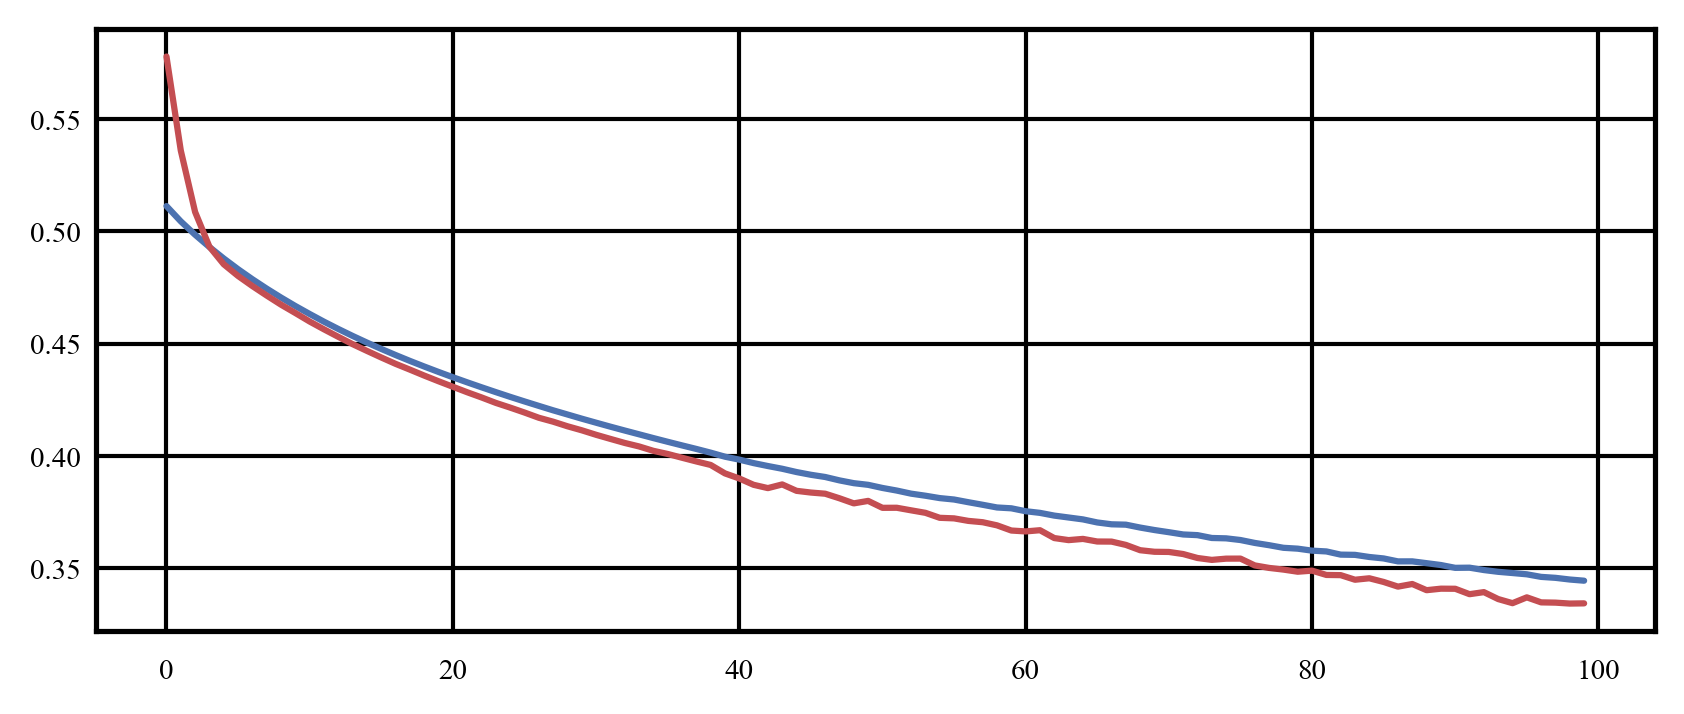

In [121]:
from turtle import color
history = ANN1.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [122]:
ANN2_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.107527,0.107527,0.105925,0.105925,0.105925,0.106566
MAE:,0.107527,0.107527,0.105925,0.105925,0.105925,0.106566
R^2:,-0.120482,-0.120482,-0.118474,-0.118474,-0.118474,-0.119277
roc_auc:,0.852460,0.940127,0.874447,0.861514,0.915765,0.888863
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.526020,0.485570,0.468376,0.566693,0.516405,0.512613


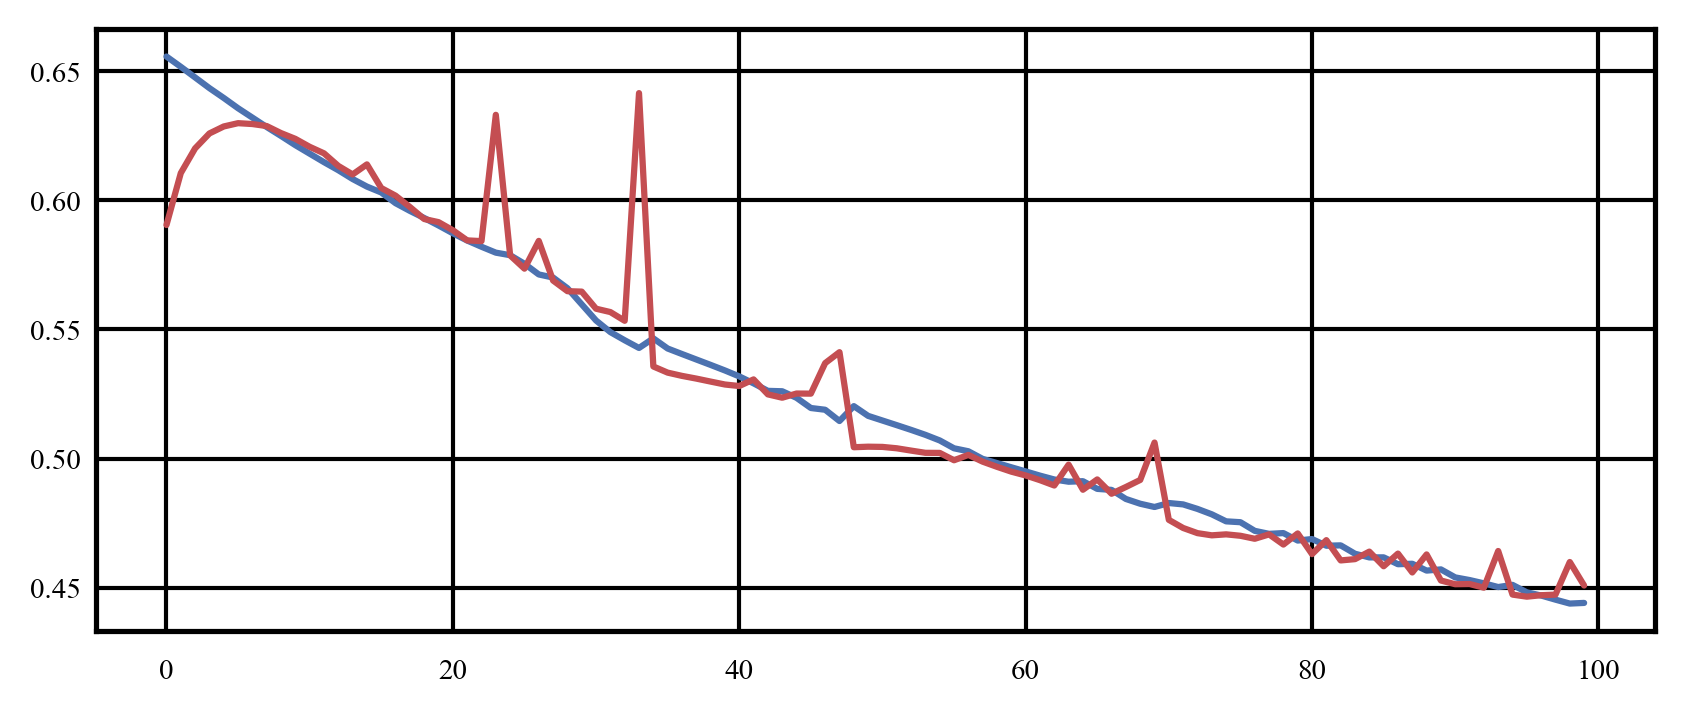

In [123]:
from turtle import color
history = ANN2.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [124]:
ANN3_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.011434,0.011434,0.011437,0.011437,0.011437,0.011436
MAE:,0.011434,0.011434,0.011437,0.011437,0.011437,0.011436
R^2:,-0.011566,-0.011566,-0.011570,-0.011570,-0.011570,-0.011568
roc_auc:,0.850760,0.880229,0.929906,0.870181,0.894081,0.885031
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.440260,0.435568,0.466752,0.458996,0.530292,0.466374


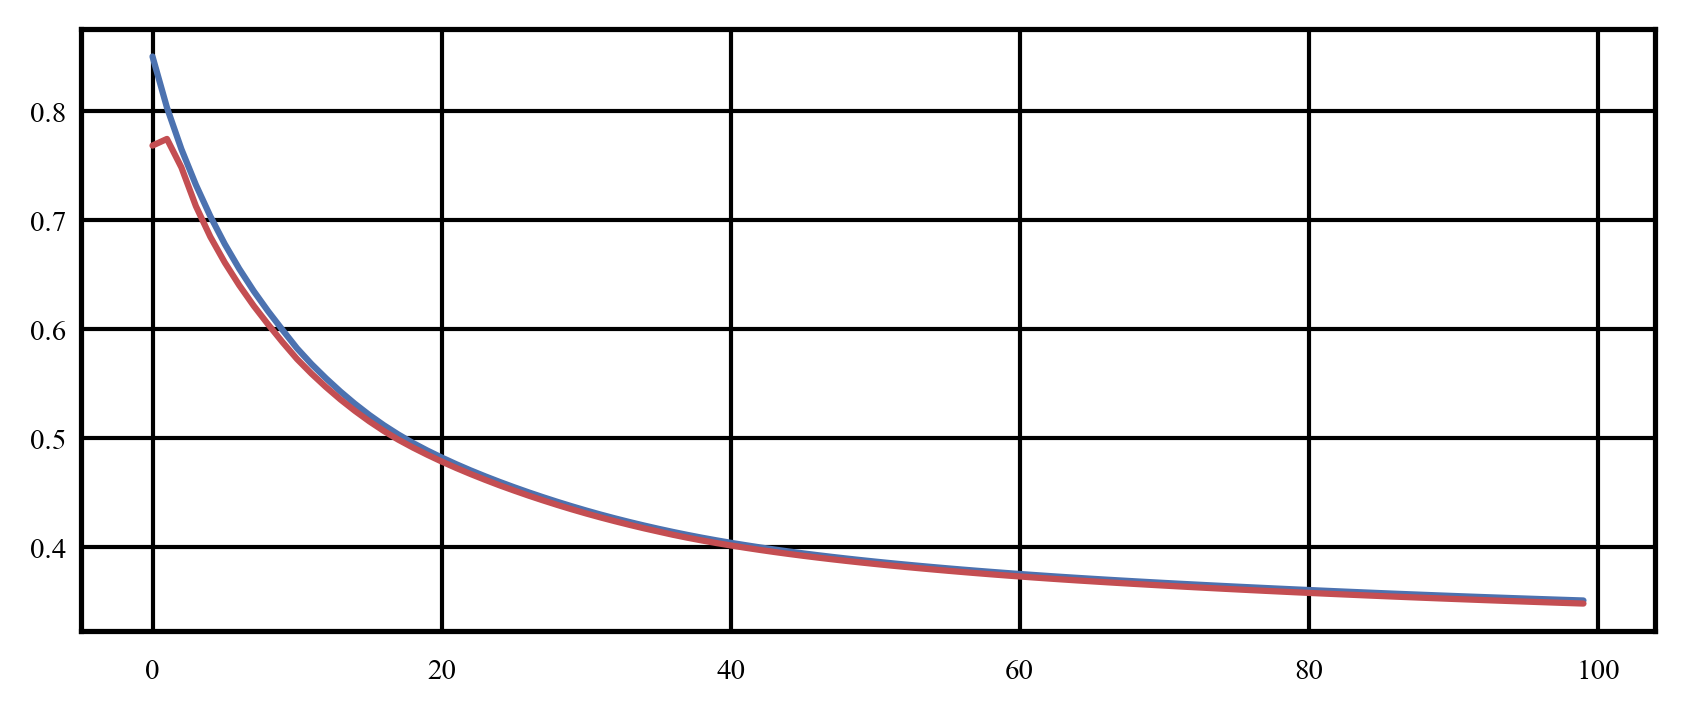

In [125]:
from turtle import color
history = ANN3.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [126]:
ANN4_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.069159,0.069159,0.069159,0.069159,0.069159,0.069159
MAE:,0.069159,0.069159,0.069159,0.069159,0.069159,0.069159
R^2:,-0.074297,-0.074297,-0.074297,-0.074297,-0.074297,-0.074297
roc_auc:,0.919950,0.879871,0.950939,0.808097,0.885596,0.888891
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.491110,0.504378,0.479020,0.559042,0.552608,0.517231


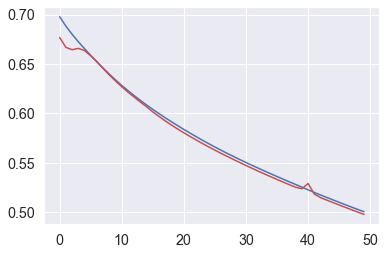

In [34]:
from turtle import color
history = ANN4.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

## Inference

In [145]:
def propensity_score_functANN(dataset,model,dataset2,dehwab):
    
    dataset2.columns = dataset2.columns.str.strip() 
    
    if dehwab == True: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]
    columns = dataset.columns
    dataset = dataset.to_numpy()
    dataset = dataset.astype(np.float32)
    #Y1 = np.reshape(Y1,(Y1.shape[0],1))
    # Generate propensity score prediction  
    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities # propensity score 
    # merge prediction and existing dataset 
    dataset = pd.DataFrame(dataset)
    dataset.columns = columns
    #dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={0:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [146]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_ANN = propensity_score_functANN(nswCps_lalonde_subset,ANN1,nswCps_lalonde,False)
nswPsid_lalonde_ps_ANN= propensity_score_functANN(nswPsid_lalonde_subset,ANN2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_ANN = propensity_score_functANN(nswCps_dehWab_subset,ANN3,nswCps_dehWab,True)
nswPsid_dehWab_ps_ANN = propensity_score_functANN(nswPsid_dehWab_subset,ANN4,nswPsid_dehWab,True)

In [147]:
# save unmatched boost datasets 
nswCps_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswCps_lalonde_ps_unmatched_ANN_FS1.csv')
nswPsid_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswPsid_lalonde_ps_unmatched_ANN_FS1.csv')
nswCps_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswCps_dehWab_ps_unmatched_ANN_FS1.csv')
nswPsid_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswPsid_dehWab_ps_unmatched_ANN_FS1.csv')

## Bar plots of model performance

In [148]:
# Average accuracy
from tueplots import axes, bundles , figsizes, fonts,fontsizes
nsw_cps_lalonde_acc = [ANN1_metrics.loc['Accuracy:','avg'],boost1_metrics.loc['Accuracy:','avg'],forest1_metrics.loc['Accuracy:','avg'],cart1_metrics.loc['Accuracy:','avg'],logit1_metrics.loc['Accuracy:','avg']]
nsw_psid_lalonde_acc = [ANN2_metrics.loc['Accuracy:','avg'],boost2_metrics.loc['Accuracy:','avg'],forest2_metrics.loc['Accuracy:','avg'],cart2_metrics.loc['Accuracy:','avg'],logit2_metrics.loc['Accuracy:','avg']]
nsw_cps_dehWab_acc = [ANN3_metrics.loc['Accuracy:','avg'],boost3_metrics.loc['Accuracy:','avg'],forest3_metrics.loc['Accuracy:','avg'],cart3_metrics.loc['Accuracy:','avg'],logit3_metrics.loc['Accuracy:','avg']]
nsw_psid_dehWab_acc = [ANN4_metrics.loc['Accuracy:','avg'],boost4_metrics.loc['Accuracy:','avg'],forest4_metrics.loc['Accuracy:','avg'],cart4_metrics.loc['Accuracy:','avg'],logit4_metrics.loc['Accuracy:','avg']]

# Average precison
nsw_cps_lalonde_prec = [ANN1_metrics.loc['Precision:','avg'],boost1_metrics.loc['Precision:','avg'],forest1_metrics.loc['Precision:','avg'],cart1_metrics.loc['Precision:','avg'],logit1_metrics.loc['Precision:','avg']]
nsw_psid_lalonde_prec = [ANN2_metrics.loc['Precision:','avg'],boost2_metrics.loc['Precision:','avg'],forest2_metrics.loc['Precision:','avg'],cart2_metrics.loc['Precision:','avg'],logit2_metrics.loc['Precision:','avg']]
nsw_cps_dehWab_prec = [ANN3_metrics.loc['Precision:','avg'],boost3_metrics.loc['Precision:','avg'],forest3_metrics.loc['Precision:','avg'],cart3_metrics.loc['Precision:','avg'],logit3_metrics.loc['Precision:','avg']]
nsw_psid_dehWab_prec = [ANN4_metrics.loc['Precision:','avg'],boost4_metrics.loc['Precision:','avg'],forest4_metrics.loc['Precision:','avg'],cart4_metrics.loc['Precision:','avg'],logit4_metrics.loc['Precision:','avg']]

# Average recall 
nsw_cps_lalonde_rec = [ANN1_metrics.loc['Recall:','avg'],boost1_metrics.loc['Recall:','avg'],forest1_metrics.loc['Recall:','avg'],cart1_metrics.loc['Recall:','avg'],logit1_metrics.loc['Recall:','avg']]
nsw_psid_lalonde_rec = [ANN2_metrics.loc['Recall:','avg'],boost2_metrics.loc['Recall:','avg'],forest2_metrics.loc['Recall:','avg'],cart2_metrics.loc['Recall:','avg'],logit2_metrics.loc['Recall:','avg']]
nsw_cps_dehWab_rec = [ANN3_metrics.loc['Recall:','avg'],boost3_metrics.loc['Recall:','avg'],forest3_metrics.loc['Recall:','avg'],cart3_metrics.loc['Recall:','avg'],logit3_metrics.loc['Recall:','avg']]
nsw_psid_dehWab_rec = [ANN4_metrics.loc['Recall:','avg'],boost4_metrics.loc['Recall:','avg'],forest4_metrics.loc['Recall:','avg'],cart4_metrics.loc['Recall:','avg'],logit4_metrics.loc['Recall:','avg']]

# Average F1 
nsw_cps_lalonde_f1 = [ANN1_metrics.loc['F1:','avg'],boost1_metrics.loc['F1:','avg'],forest1_metrics.loc['F1:','avg'],cart1_metrics.loc['F1:','avg'],logit1_metrics.loc['F1:','avg']]
nsw_psid_lalonde_f1 = [ANN2_metrics.loc['F1:','avg'],boost2_metrics.loc['F1:','avg'],forest2_metrics.loc['F1:','avg'],cart2_metrics.loc['F1:','avg'],logit2_metrics.loc['F1:','avg']]
nsw_cps_dehWab_f1 = [ANN3_metrics.loc['F1:','avg'],boost3_metrics.loc['F1:','avg'],forest3_metrics.loc['F1:','avg'],cart3_metrics.loc['F1:','avg'],logit3_metrics.loc['F1:','avg']]
nsw_psid_dehWab_f1 = [ANN4_metrics.loc['F1:','avg'],boost4_metrics.loc['F1:','avg'],forest4_metrics.loc['F1:','avg'],cart4_metrics.loc['F1:','avg'],logit4_metrics.loc['F1:','avg']]

# Average log loss
nsw_cps_lalonde_logloss = [ANN1_metrics.loc['logloss:','avg'],boost1_metrics.loc['log-loss:','avg'],forest1_metrics.loc['log-loss:','avg'],cart1_metrics.loc['log-loss:','avg'],logit1_metrics.loc['log-loss:','avg']]
nsw_psid_lalonde_logloss = [ANN2_metrics.loc['logloss:','avg'],boost2_metrics.loc['log-loss:','avg'],forest2_metrics.loc['log-loss:','avg'],cart2_metrics.loc['log-loss:','avg'],logit2_metrics.loc['log-loss:','avg']]
nsw_cps_dehWab_logloss = [ANN3_metrics.loc['logloss:','avg'],boost3_metrics.loc['log-loss:','avg'],forest3_metrics.loc['log-loss:','avg'],cart3_metrics.loc['log-loss:','avg'],logit3_metrics.loc['log-loss:','avg']]
nsw_psid_dehWab_logloss = [ANN4_metrics.loc['logloss:','avg'],boost4_metrics.loc['log-loss:','avg'],forest4_metrics.loc['log-loss:','avg'],cart4_metrics.loc['log-loss:','avg'],logit4_metrics.loc['log-loss:','avg']]

# Average Roc Auc 
nsw_cps_lalonde_rocauc = [ANN1_metrics.loc['roc_auc:','avg'],boost1_metrics.loc['roc_auc:','avg'],forest1_metrics.loc['roc_auc:','avg'],cart1_metrics.loc['roc_auc:','avg'],logit1_metrics.loc['roc_auc:','avg']]
nsw_psid_lalonde_rocauc = [ANN2_metrics.loc['roc_auc:','avg'],boost2_metrics.loc['roc_auc:','avg'],forest2_metrics.loc['roc_auc:','avg'],cart2_metrics.loc['roc_auc:','avg'],logit2_metrics.loc['roc_auc:','avg']]
nsw_cps_dehWab_rocauc = [ANN3_metrics.loc['roc_auc:','avg'],boost3_metrics.loc['roc_auc:','avg'],forest3_metrics.loc['roc_auc:','avg'],cart3_metrics.loc['roc_auc:','avg'],logit3_metrics.loc['roc_auc:','avg']]
nsw_psid_dehWab_rocauc = [ANN4_metrics.loc['roc_auc:','avg'],boost4_metrics.loc['roc_auc:','avg'],forest4_metrics.loc['roc_auc:','avg'],cart4_metrics.loc['roc_auc:','avg'],logit4_metrics.loc['roc_auc:','avg']]

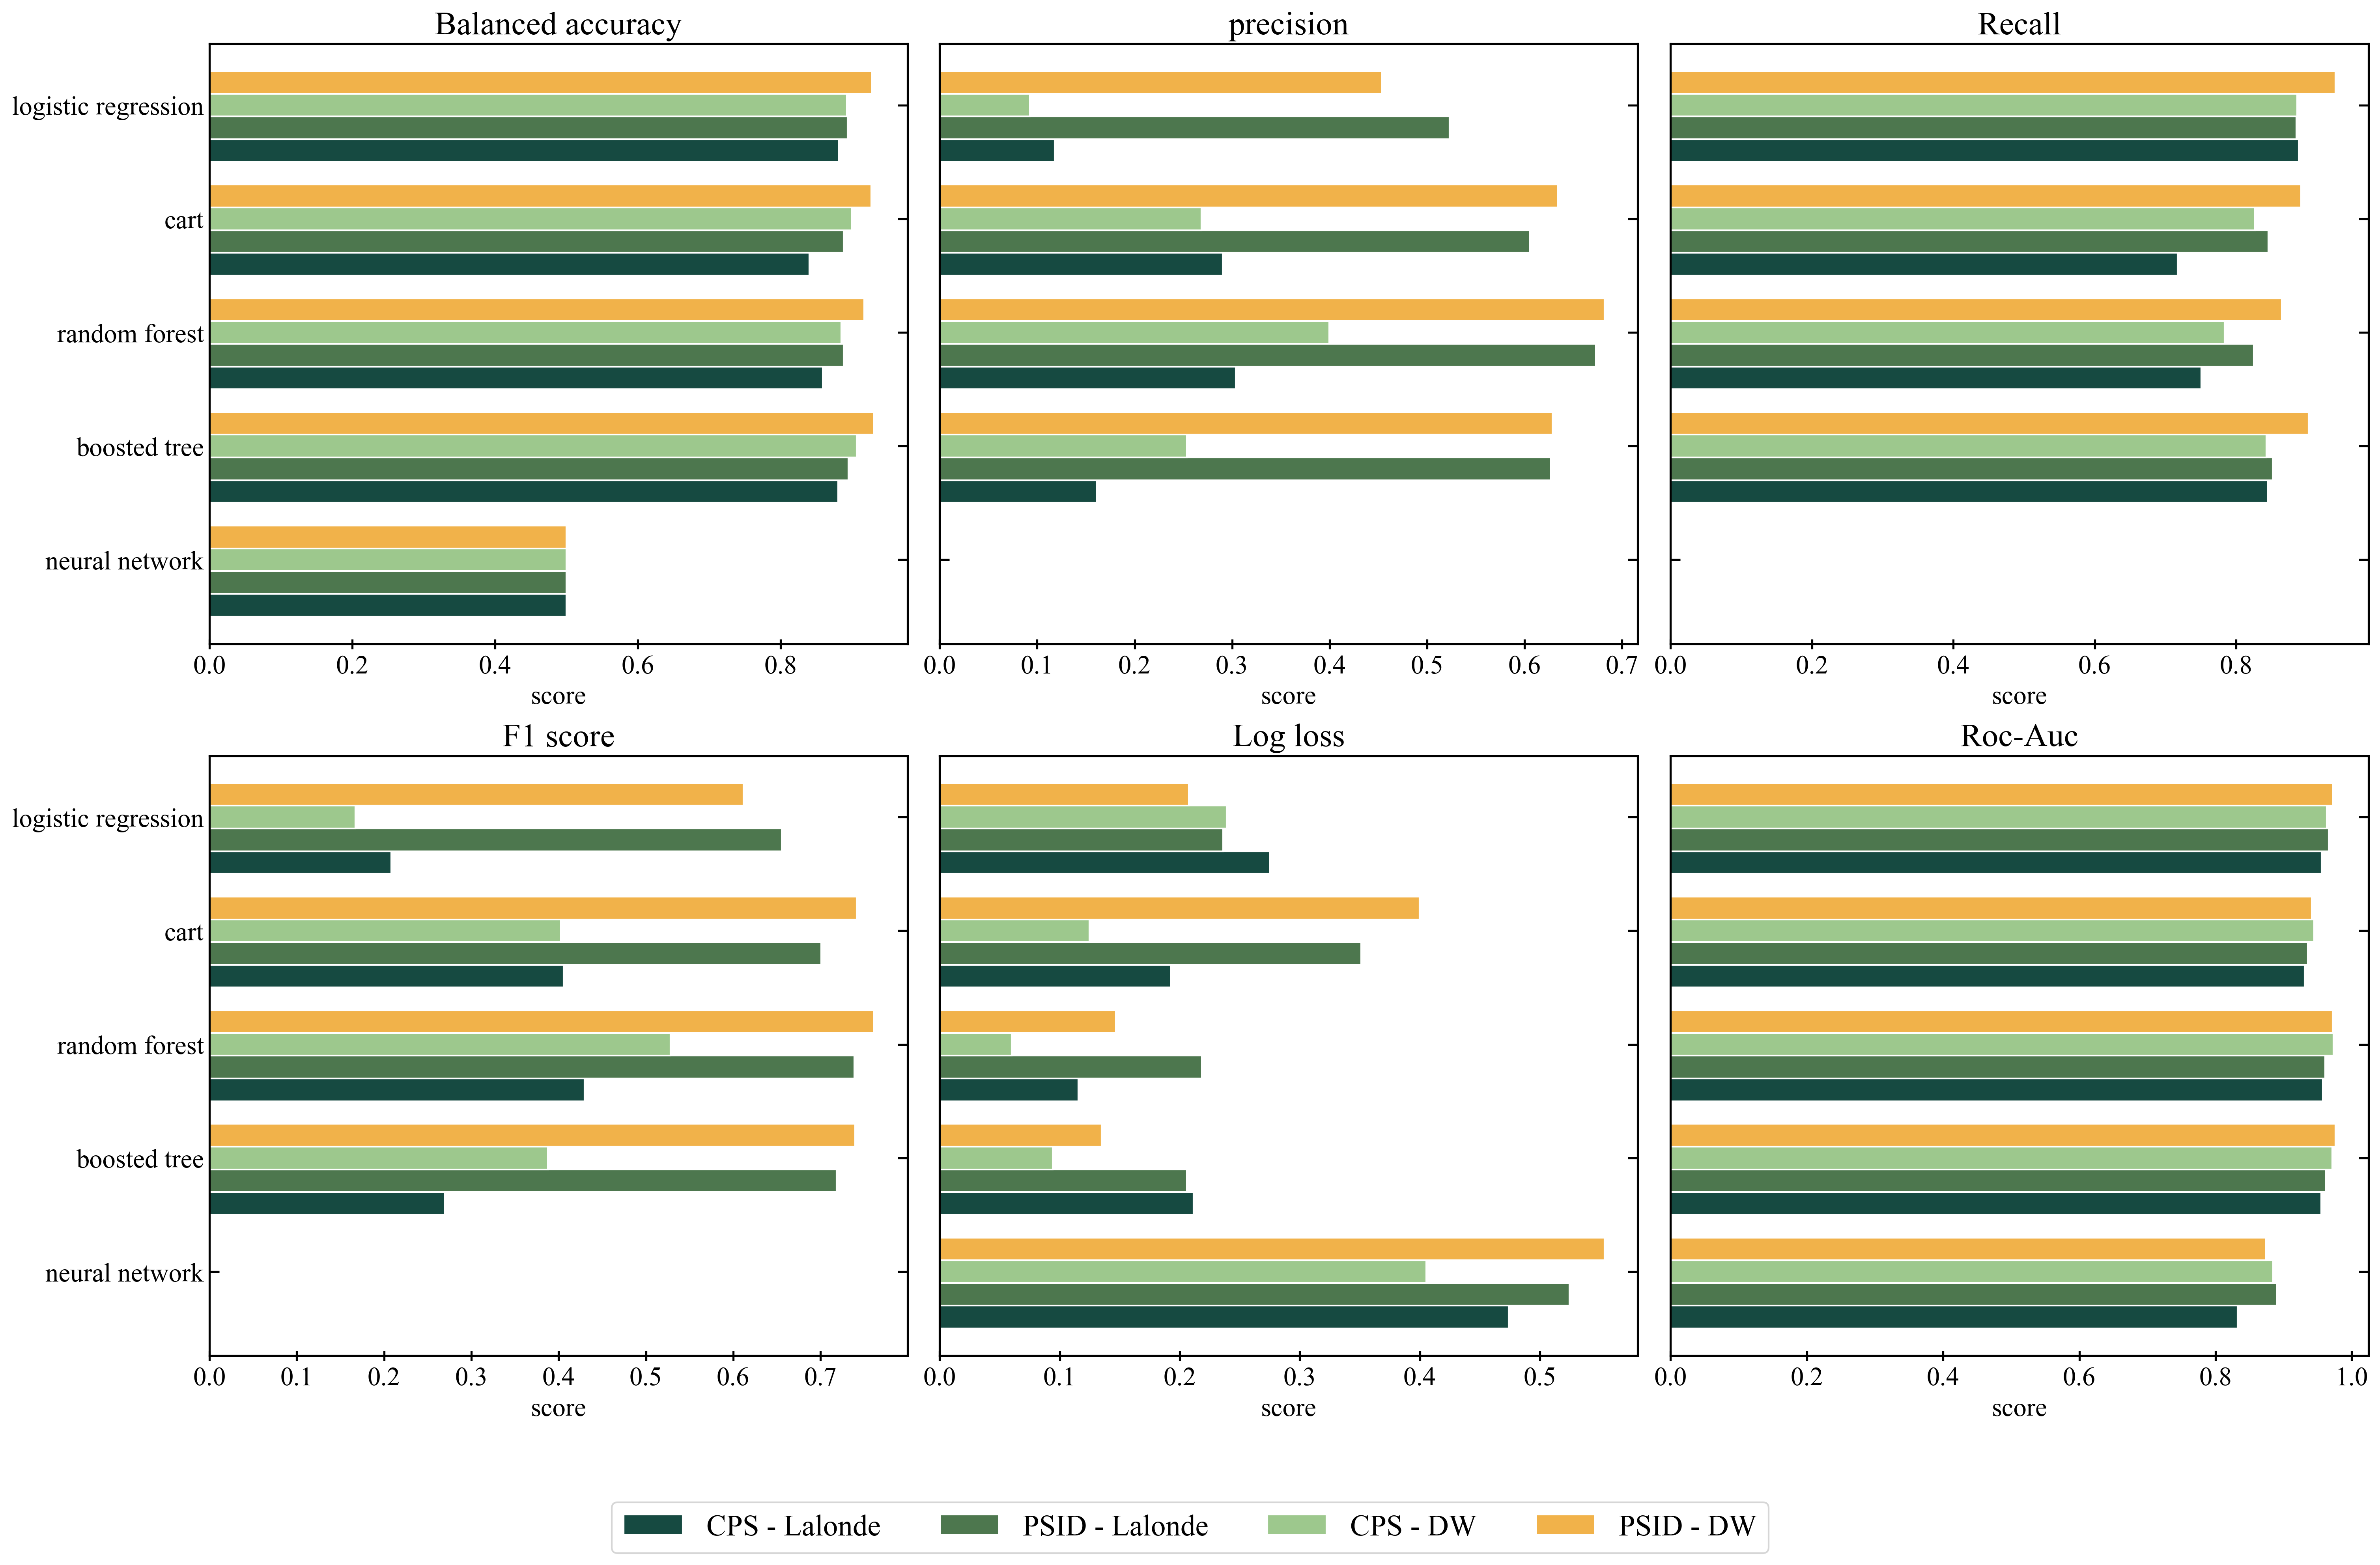

In [149]:
# Create plot 
# Update plot paramaters 
fig, ax = plt.subplots(nrows=2, ncols=3,figsize = (20,12))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 300}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=3))
plt.rcParams.update({'font.size': 18})
y = np.arange(5)
x = np.arange(1)
width = 0.2
# Balanced accuracy

ax[0,0].set_title("Balanced accuracy",fontsize=20)
ax[0,0].set_xlabel('score',fontsize=16)
ax[0,0].set_yticks(y+2*width, ['neural network', 'boosted tree', 'random forest', 'cart', 'logistic regression'],fontsize=16)
ax[0,0].tick_params(axis='x', which='major', labelsize=16)

colour1 = "#164A41" # CPS lalonde
colour2 = "#4D774E" # PSID lalonde
colour3 = "#9DC88D" # CPS dehwab
colour4 = "#F1B24A" # PSID dehwab

ax[0,0].barh(y,nsw_cps_lalonde_acc,width,color = colour1)
ax[0,0].barh(y+width,nsw_psid_lalonde_acc,width,color = colour2)
ax[0,0].barh(y+2*width,nsw_cps_dehWab_acc,width,color = colour3)
ax[0,0].barh(y+(3*width),nsw_psid_dehWab_acc,width,color = colour4)

ax[0,0].set_facecolor('white')
ax[0,0].grid(color='white', axis='y')
ax[0,0].grid(color='white', axis='x')
ax[0,0].spines['left']
ax[0,0].spines['right']
ax[0,0].spines['bottom']
ax[0,0].tick_params(right='on')
ax[0,0].tick_params(left='on')
ax[0,0].tick_params(bottom='on')

# precision

ax[0,1].set_title("precision",fontsize=20)
ax[0,1].set_xlabel('score',fontsize=16)
ax[0,1].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[0,1].tick_params(axis='x', which='major', labelsize=16)

ax[0,1].barh(y,nsw_cps_lalonde_prec,width,color = colour1)
ax[0,1].barh(y+width,nsw_psid_lalonde_prec,width,color = colour2)
ax[0,1].barh(y+2*width,nsw_cps_dehWab_prec,width,color = colour3)
ax[0,1].barh(y+(3*width),nsw_psid_dehWab_prec,width,color = colour4)

ax[0,1].set_facecolor('white')
ax[0,1].grid(color='white', axis='y')
ax[0,1].grid(color='white', axis='x')
ax[0,1].spines['left']
ax[0,1].spines['right']
ax[0,1].spines['bottom']
ax[0,1].tick_params(right='on')
ax[0,1].tick_params(left='on')
ax[0,1].tick_params(bottom='on')

# recall 

ax[0,2].set_title("Recall",fontsize=20)
ax[0,2].set_xlabel('score',fontsize=16)
ax[0,2].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[0,2].tick_params(axis='x', which='major', labelsize=16)

ax[0,2].barh(y,nsw_cps_lalonde_rec,width,color = colour1)
ax[0,2].barh(y+width,nsw_psid_lalonde_rec,width,color = colour2)
ax[0,2].barh(y+2*width,nsw_cps_dehWab_rec,width,color = colour3)
ax[0,2].barh(y+(3*width),nsw_psid_dehWab_rec,width,color = colour4)

ax[0,2].set_facecolor('white')
ax[0,2].grid(color='white', axis='y')
ax[0,2].grid(color='white', axis='x')
ax[0,2].spines['left']
ax[0,2].spines['right']
ax[0,2].spines['bottom']
ax[0,2].tick_params(right='on')
ax[0,2].tick_params(left='on')
ax[0,2].tick_params(bottom='on')

# F1
ax[1,0].set_title("F1 score",fontsize=20)
ax[1,0].set_xlabel('score',fontsize=16)
ax[1,0].set_yticks(y+2*width, ['neural network', 'boosted tree', 'random forest', 'cart', 'logistic regression'],fontsize=16)
ax[1,0].tick_params(axis='x', which='major', labelsize=16)

ax[1,0].barh(y,nsw_cps_lalonde_f1,width,color = colour1)
ax[1,0].barh(y+width,nsw_psid_lalonde_f1,width,color = colour2)
ax[1,0].barh(y+2*width,nsw_cps_dehWab_f1,width,color = colour3)
ax[1,0].barh(y+(3*width),nsw_psid_dehWab_f1,width,color = colour4)

ax[1,0].set_facecolor('white')
ax[1,0].grid(color='white', axis='y')
ax[1,0].grid(color='white', axis='x')
ax[1,0].spines['left']
ax[1,0].spines['right']
ax[1,0].spines['bottom']
ax[1,0].tick_params(right='on')
ax[1,0].tick_params(left='on')
ax[1,0].tick_params(bottom='on')


# Log loss
ax[1,1].set_title("Log loss",fontsize=20)
ax[1,1].set_xlabel('score',fontsize=16)
ax[1,1].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[1,1].tick_params(axis='x', which='major', labelsize=16)

ax[1,1].barh(y,nsw_cps_lalonde_logloss,width,color = colour1)
ax[1,1].barh(y+width,nsw_psid_lalonde_logloss,width,color = colour2)
ax[1,1].barh(y+2*width,nsw_cps_dehWab_logloss,width,color = colour3)
ax[1,1].barh(y+(3*width),nsw_psid_dehWab_logloss,width,color = colour4)

ax[1,1].set_facecolor('white')
ax[1,1].grid(color='white', axis='y')
ax[1,1].grid(color='white', axis='x')
ax[1,1].spines['left']
ax[1,1].spines['right']
ax[1,1].spines['bottom']
ax[1,1].tick_params(right='on')
ax[1,1].tick_params(left='on')
ax[1,1].tick_params(bottom='on')

# Roc-AUC
ax[1,2].set_title("Roc-Auc",fontsize=20)
ax[1,2].set_xlabel('score',fontsize=16)
ax[1,2].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[1,2].tick_params(axis='x', which='major', labelsize=16)

ax[1,2].barh(y,nsw_cps_lalonde_rocauc,width,color = colour1)
ax[1,2].barh(y+width,nsw_psid_lalonde_rocauc,width,color = colour2)
ax[1,2].barh(y+2*width,nsw_cps_dehWab_rocauc,width,color = colour3)
ax[1,2].barh(y+(3*width),nsw_psid_dehWab_rocauc,width,color = colour4)

ax[1,2].set_facecolor('white')
ax[1,2].grid(color='white', axis='y')
ax[1,2].grid(color='white', axis='x')
ax[1,2].spines['left']
ax[1,2].spines['right']
ax[1,2].spines['bottom']
ax[1,2].tick_params(right='on')
ax[1,2].tick_params(left='on')
ax[1,2].tick_params(bottom='on')

labels = ['CPS - Lalonde','PSID - Lalonde','CPS - DW','PSID - DW']
fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(labels),markerscale=3, bbox_transform=fig.transFigure,prop={'size': 18})

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/training_evaluation_averages_feat_select.png', bbox_inches='tight')
plt.show()

### Analysis on model outptus - Probability calibration curves 

In [19]:
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

In [17]:
from sklearn import tree      
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier    

In [18]:

# Take a random sample from the data with an even number of treated and control for testing

nswCps_lalonde_valid = nswCps_lalonde.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswCps_lalonde = nswCps_lalonde.drop(nswCps_lalonde_valid.index) # Remove all samples from training which are in the sample 

nswPsid_lalonde_valid = nswPsid_lalonde.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswPsid_lalonde = nswPsid_lalonde.drop(nswPsid_lalonde_valid.index) # Remove all samples from training which are in the sample 

nswCps_dehWab_valid = nswCps_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswCps_dehWab = nswCps_dehWab.drop(nswCps_dehWab_valid.index)# Remove all samples from training which are in the sample 

nswPsid_Dehwab_valid = nswPsid_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswPsid_dehWab = nswPsid_dehWab.drop(nswPsid_Dehwab_valid.index) # Remove all samples from training which are in the sample 


# covariates used in each mdoel 
logit_vars = ['treat','education*','black','hispanic','married','married_u75','nodegree','re75']
logit_vars2 = ['treat','age','education*','black','married','hispanic','black_education','hisp_re75','nodegree','re75']
tree_vars = ['treat','age','black','education*','married','nodegree','re75']
tree_vars2 =  ['treat','age','black','education*','married','nodegree','re74','re75']

nswre74_continuos_vars2 = ['ageboxcox','re74','re75',] 
ann_vars = ['treat','ageboxcox','black','education*','married','nodegree','re75'] 
ann_vars2 =['treat','ageboxcox','black','education*','married','nodegree','re74','re75'] 
continuos_vars = ['ageboxcox','re75'] 
continuos_vars2= ['ageboxcox','re74','re75'] 
# ======== Lalonde - sample ======== #

# ~~~~~~~~~~
# 1 cps
# ~~~~~~~~~~

#logit model 
cps_lalonde_subset_logit = nswCps_lalonde[logit_vars]
cps_lalonde_subset_valid_logit = nswCps_lalonde_valid[logit_vars]
#decision tree models 
cps_lalonde_subset_trees = nswCps_lalonde[tree_vars]
cps_lalonde_subset_valid_trees = nswCps_lalonde_valid[tree_vars]
#ann model 
cps_lalonde_subset_ann = nswCps_lalonde[ann_vars]
cps_lalonde_subset_valid_ann = nswCps_lalonde_valid[ann_vars]
cps_lalonde_subset_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_ann[continuos_vars])
cps_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_valid_ann[continuos_vars])

# ~~~~~~~~~~
# 2 PSID 
# ~~~~~~~~~~

#logit model 
psid_lalonde_subset_logit = nswPsid_lalonde[logit_vars]
psid_lalonde_subset_valid_logit = nswPsid_lalonde_valid[logit_vars]
#decision tree models 
psid_lalonde_subset_trees = nswPsid_lalonde[tree_vars]
psid_lalonde_subset_valid_trees = nswPsid_lalonde_valid[tree_vars]
#ann model 
psid_lalonde_subset_ann = nswPsid_lalonde[ann_vars]
psid_lalonde_subset_valid_ann = nswPsid_lalonde_valid[ann_vars]
psid_lalonde_subset_ann[continuos_vars] = sc.fit_transform(psid_lalonde_subset_ann[continuos_vars])
psid_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(psid_lalonde_subset_valid_ann[continuos_vars])


# ======== Dehejia - Wahba sample ======== #

# ~~~~~~~~~~
# 3 CPS
# ~~~~~~~~~~
# logit 
cps_dehWab_subset_logit = nswCps_dehWab[logit_vars2]
cps_dehWab_subset_valid_logit = nswCps_dehWab_valid[logit_vars2]
# decision tree's
cps_dehWab_subset_trees = nswCps_dehWab[tree_vars2]
cps_dehWab_subset_valid_trees = nswCps_dehWab_valid[tree_vars2]
#ann
cps_dehWab_subset_ann = nswCps_dehWab[ann_vars2]
cps_dehWab_subset_valid_ann = nswCps_dehWab_valid[ann_vars2]
cps_dehWab_subset_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_ann[continuos_vars])
cps_dehWab_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_valid_ann[continuos_vars])

# ~~~~~~~~~~
# 4 PSID
# ~~~~~~~~~~
# logit 
psid_dehWab_subset_logit = nswCps_dehWab[logit_vars2]
psid_dehWab_subset_valid_logit = nswCps_dehWab_valid[logit_vars2]
# decision tree's
psid_dehWab_subset_trees = nswCps_dehWab[tree_vars2]
psid_dehWab_subset_valid_trees = nswCps_dehWab_valid[tree_vars2]
#ann
psid_dehWab_subset_ann = nswCps_dehWab[ann_vars2]
psid_dehWab_subset_valid_ann = nswCps_dehWab_valid[ann_vars2]
psid_dehWab_subset_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_ann[continuos_vars])
psid_dehWab_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_valid_ann[continuos_vars])

/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_1618/1402125294.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cps_lalonde_subset_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_ann[continuos_vars])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_1618/1402125294.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cps_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_valid_ann[continuos_vars])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T

In [19]:
# Function to run all models and get a prediction - using the best features from our grid search 
# Inputs are the dataset's we want to look at 


def fit_and_predict_all_models(logit_data,logit_valid,tree_data,tree_valid,ann_data,ann_valid,neuralnet):
    
    '''
    could make this function do all the smote and rejoing the validation set again sincce i am making my own, so there are more training examples
    
    '''
   
  
    
    #Train test split 
    def return_trainTest_split(Dataset):
        # shuffle data
        Dataset = Dataset.sample(frac = 1,random_state=0)
        Features = Dataset.drop('treat', axis=1)
        Target = Dataset['treat']
        X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.3, shuffle=True)
        return X_train, X_test, y_train, y_test;

    
    resample=SMOTEENN(random_state=0) # resampling
    
    '''
    '''
    
    # Logit
    
    X_train1, X_test1, y_train1, y_test1 = return_trainTest_split(logit_data)
    X_train1, y_train1 = resample.fit_resample(X_train1, y_train1)	
    
    shuffled = pd.concat([pd.DataFrame(X_train1),pd.DataFrame(y_train1)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train1, y_train1 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
    
    logit_demo = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
    
    logit_demo.fit(X_train1,y_train1)
    
    logit_valid = logit_valid.sample(frac = 1,random_state=0)
    X_test1 = logit_valid.drop('treat',axis=1, inplace = False)
    y_test1 = logit_valid['treat']
    
    predicted_proba_logit = logit_demo.predict_proba(X_test1)
    
    
    
    # Decision tree models 
    
    X_train2, X_test2, y_train2, y_test2 = return_trainTest_split(tree_data)

    X_train2, y_train2 = resample.fit_resample(X_train2, y_train2)	
    shuffled = pd.concat([pd.DataFrame(X_train2),pd.DataFrame(y_train2)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train2, y_train2 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]

    tree_valid = tree_valid.sample(frac = 1,random_state=0)
    X_test2 = tree_valid.drop('treat',axis=1, inplace = False)
    y_test2 = tree_valid['treat']

    # Cart
    
    CART_demo = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5, max_leaf_nodes=12,min_samples_leaf=2)
    CART_demo.fit(X_train2,y_train2)
    predicted_proba_cart = CART_demo.predict_proba(X_test2)
    #RF
    forest_demo = RandomForestClassifier(random_state=0,criterion='entropy',max_depth=8,max_features='auto',min_samples_split=3,n_estimators=500)
    forest_demo.fit(X_train2,y_train2)
    predicted_proba_forest = forest_demo.predict_proba(X_test2)
    #boost
    boost_demo = XGBClassifier(objective= 'binary:logistic',booser='dart',colsample_bytree=0.3,gamma=0.5,learning_rate=0.05,mind_child_weight=1,subsample=0.5,seed=0,nthread=4)  
    boost_demo.fit(X_train2,y_train2)
    predicted_proba_boost = boost_demo.predict_proba(X_test2)

    #ANN
    X_train3, X_test3, y_train3, y_test3 = return_trainTest_split(ann_data)
    X_train3, y_train3 = resample.fit_resample(X_train3, y_train3)	
    shuffled = pd.concat([pd.DataFrame(X_train3),pd.DataFrame(y_train3)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train3, y_train3 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]

    ann_valid = ann_valid.sample(frac = 1,random_state=0)
    X_test3 = ann_valid.drop('treat',axis=1, inplace = False)
    y_test3 = ann_valid['treat']

    Epochs = 100
    learning_rate = 0.0001
    weight_decay = 0.05
    batch_size = 256

    X_train3 = X_train3.to_numpy()
    y_train3 = y_train3.to_numpy()
    X_train3 = X_train3.astype(np.float32)
    y_train3 = y_train3.astype(np.float32)
    y_train3 = np.reshape(y_train3,(y_train3.shape[0],1))

    X_test3 = X_test3.to_numpy()
    y_test3 = y_test3.to_numpy()
    X_test3 = X_test3.astype(np.float32)
    y_test3 = y_test3.astype(np.float32)
    y_test3 = np.reshape(y_test3,(y_test3.shape[0],1))

    ann_demo = NeuralNetClassifier(neuralnet,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False,verbose=0 )

    ann_demo.fit(X_train3,y_train3)
    predicted_proba_ANN = ann_demo.predict_proba(X_test3)
    
    return predicted_proba_logit,predicted_proba_cart,predicted_proba_forest,predicted_proba_boost,predicted_proba_ANN,y_test1,y_test2,y_test3;

    
    

In [20]:
logit_proba1,cart_proba1,forest_proba1,boost_proba1,ann_proba1,yl1,yt1,ya1 = fit_and_predict_all_models(cps_lalonde_subset_logit,
                                                                                            cps_lalonde_subset_valid_logit,
                                                                                            cps_lalonde_subset_trees,
                                                                                            cps_lalonde_subset_valid_trees,
                                                                                            cps_lalonde_subset_ann,
                                                                                            cps_lalonde_subset_valid_ann,
                                                                                            twoLayerNN1)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[09:52:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




: 

In [24]:
logit_proba2,cart_proba2,forest_proba2,boost_proba2,ann_proba2,yl2,yt2,ya2 = fit_and_predict_all_models(psid_lalonde_subset_logit,
                                                                                            psid_lalonde_subset_valid_logit,
                                                                                            psid_lalonde_subset_trees,
                                                                                            psid_lalonde_subset_valid_trees,
                                                                                            psid_lalonde_subset_ann,
                                                                                            psid_lalonde_subset_valid_ann,
                                                                                            twoLayerNN1)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[06:53:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [25]:
cps_dehWab_subset_ann

,treat,ageboxcox,black,education*,married,nodegree,re74,re75
0,1.0,0.654479,1.0,11,1.0,1.0,0,0.000000
1,1.0,0.237082,0.0,9,0.0,1.0,0,0.000000
3,1.0,0.396870,1.0,11,0.0,1.0,0,0.000000
4,1.0,0.559247,1.0,8,0.0,1.0,0,0.000000
5,1.0,0.237082,1.0,9,0.0,1.0,0,0.000000
...,...,...,...,...,...,...,...,...
16172,0.0,0.237082,1.0,12,0.0,0.0,3975,0.269421
16173,0.0,0.164698,1.0,12,1.0,0.0,1445,0.468724
16174,0.0,0.654479,0.0,12,0.0,0.0,1733,0.061760
16175,0.0,0.860044,0.0,9,1.0,1.0,16914,0.450977


In [26]:
cps_dehWab_subset_valid_ann

,treat,ageboxcox,black,education*,married,nodegree,re74,re75
6546,0.0,0.271267,0.0,12,1.0,0.0,13732,0.485362
10492,0.0,0.425865,0.0,12,1.0,0.0,25862,1.000000
14196,0.0,0.425865,0.0,12,1.0,0.0,14694,0.586737
7436,0.0,0.607980,0.0,12,1.0,0.0,25862,1.000000
5087,0.0,0.425865,0.0,12,1.0,0.0,25862,1.000000
...,...,...,...,...,...,...,...,...
69,1.0,0.454023,1.0,13,0.0,0.0,0,0.000000
74,1.0,0.425865,1.0,15,0.0,0.0,0,0.000000
51,1.0,0.508028,1.0,11,1.0,1.0,0,0.000000
13,1.0,0.396870,1.0,10,1.0,1.0,0,0.000000


In [27]:
logit_proba3,cart_proba3,forest_proba3,boost_proba3,ann_proba3,yl3,yt3,ya3 = fit_and_predict_all_models(cps_dehWab_subset_logit,
                                                                                            cps_dehWab_subset_valid_logit,
                                                                                            cps_dehWab_subset_trees,
                                                                                            cps_dehWab_subset_valid_trees,
                                                                                            cps_dehWab_subset_ann,
                                                                                            cps_dehWab_subset_valid_ann,
                                                                                            twoLayerNN3)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[06:53:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [28]:
logit_proba4,cart_proba4,forest_proba4,boost_proba4,ann_proba4,yl4,yt4,ya4 = fit_and_predict_all_models(psid_dehWab_subset_logit,
                                                                                            psid_dehWab_subset_valid_logit,
                                                                                            psid_dehWab_subset_trees,
                                                                                            psid_dehWab_subset_valid_trees,
                                                                                            psid_dehWab_subset_ann,
                                                                                            psid_dehWab_subset_valid_ann,
                                                                                            twoLayerNN4)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[06:54:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [32]:
# Calibration curve for each models prediction 
from sklearn.calibration import calibration_curve
logit_fop1  , logit_mpv1  = calibration_curve(yl1, logit_proba1[:,1], n_bins=10, normalize=True)
cart_fop1   , cart_mpv1   = calibration_curve(yt1, cart_proba1[:,1], n_bins=10, normalize=True)
forest_fop1  , forest_mpv1 = calibration_curve(yt1, forest_proba1[:,1], n_bins=10, normalize=True)
boost_fop1  , boost_mpv1  = calibration_curve(yt1, boost_proba1[:,1], n_bins=10, normalize=True)
ann_fop1    , ann_mpv1    = calibration_curve(ya1, ann_proba1, n_bins=10, normalize=True)

logit_fop2  , logit_mpv2  = calibration_curve(yl2, logit_proba2[:,1], n_bins=10, normalize=True)
cart_fop2   , cart_mpv2   = calibration_curve(yt2, cart_proba2[:,1], n_bins=10, normalize=True)
forest_fop2  , forest_mpv2 = calibration_curve(yt2, forest_proba2[:,1], n_bins=10, normalize=True)
boost_fop2  , boost_mpv2  = calibration_curve(yt2, boost_proba2[:,1], n_bins=10, normalize=True)
ann_fop2    , ann_mpv2    = calibration_curve(ya2, ann_proba2, n_bins=10, normalize=True)

logit_fop3  , logit_mpv3  = calibration_curve(yl3, logit_proba3[:,1], n_bins=10, normalize=True)
cart_fop3   , cart_mpv3   = calibration_curve(yt3, cart_proba3[:,1], n_bins=10, normalize=True)
forest_fop3  , forest_mpv3 = calibration_curve(yt3, forest_proba3[:,1], n_bins=10, normalize=True)
boost_fop3  , boost_mpv3  = calibration_curve(yt3, boost_proba3[:,1], n_bins=10, normalize=True)
ann_fop3    , ann_mpv3    = calibration_curve(ya3, ann_proba3, n_bins=10, normalize=True)

logit_fop4  , logit_mpv4  = calibration_curve(yl4, logit_proba4[:,1], n_bins=10, normalize=True)
cart_fop4   , cart_mpv4   = calibration_curve(yt4, cart_proba4[:,1], n_bins=10, normalize=True)
forest_fop4  , forest_mpv4 = calibration_curve(yt4, forest_proba4[:,1], n_bins=10, normalize=True)
boost_fop4  , boost_mpv4  = calibration_curve(yt4, boost_proba4[:,1], n_bins=10, normalize=True)
ann_fop4    , ann_mpv4    = calibration_curve(ya4, ann_proba4, n_bins=10, normalize=True)


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


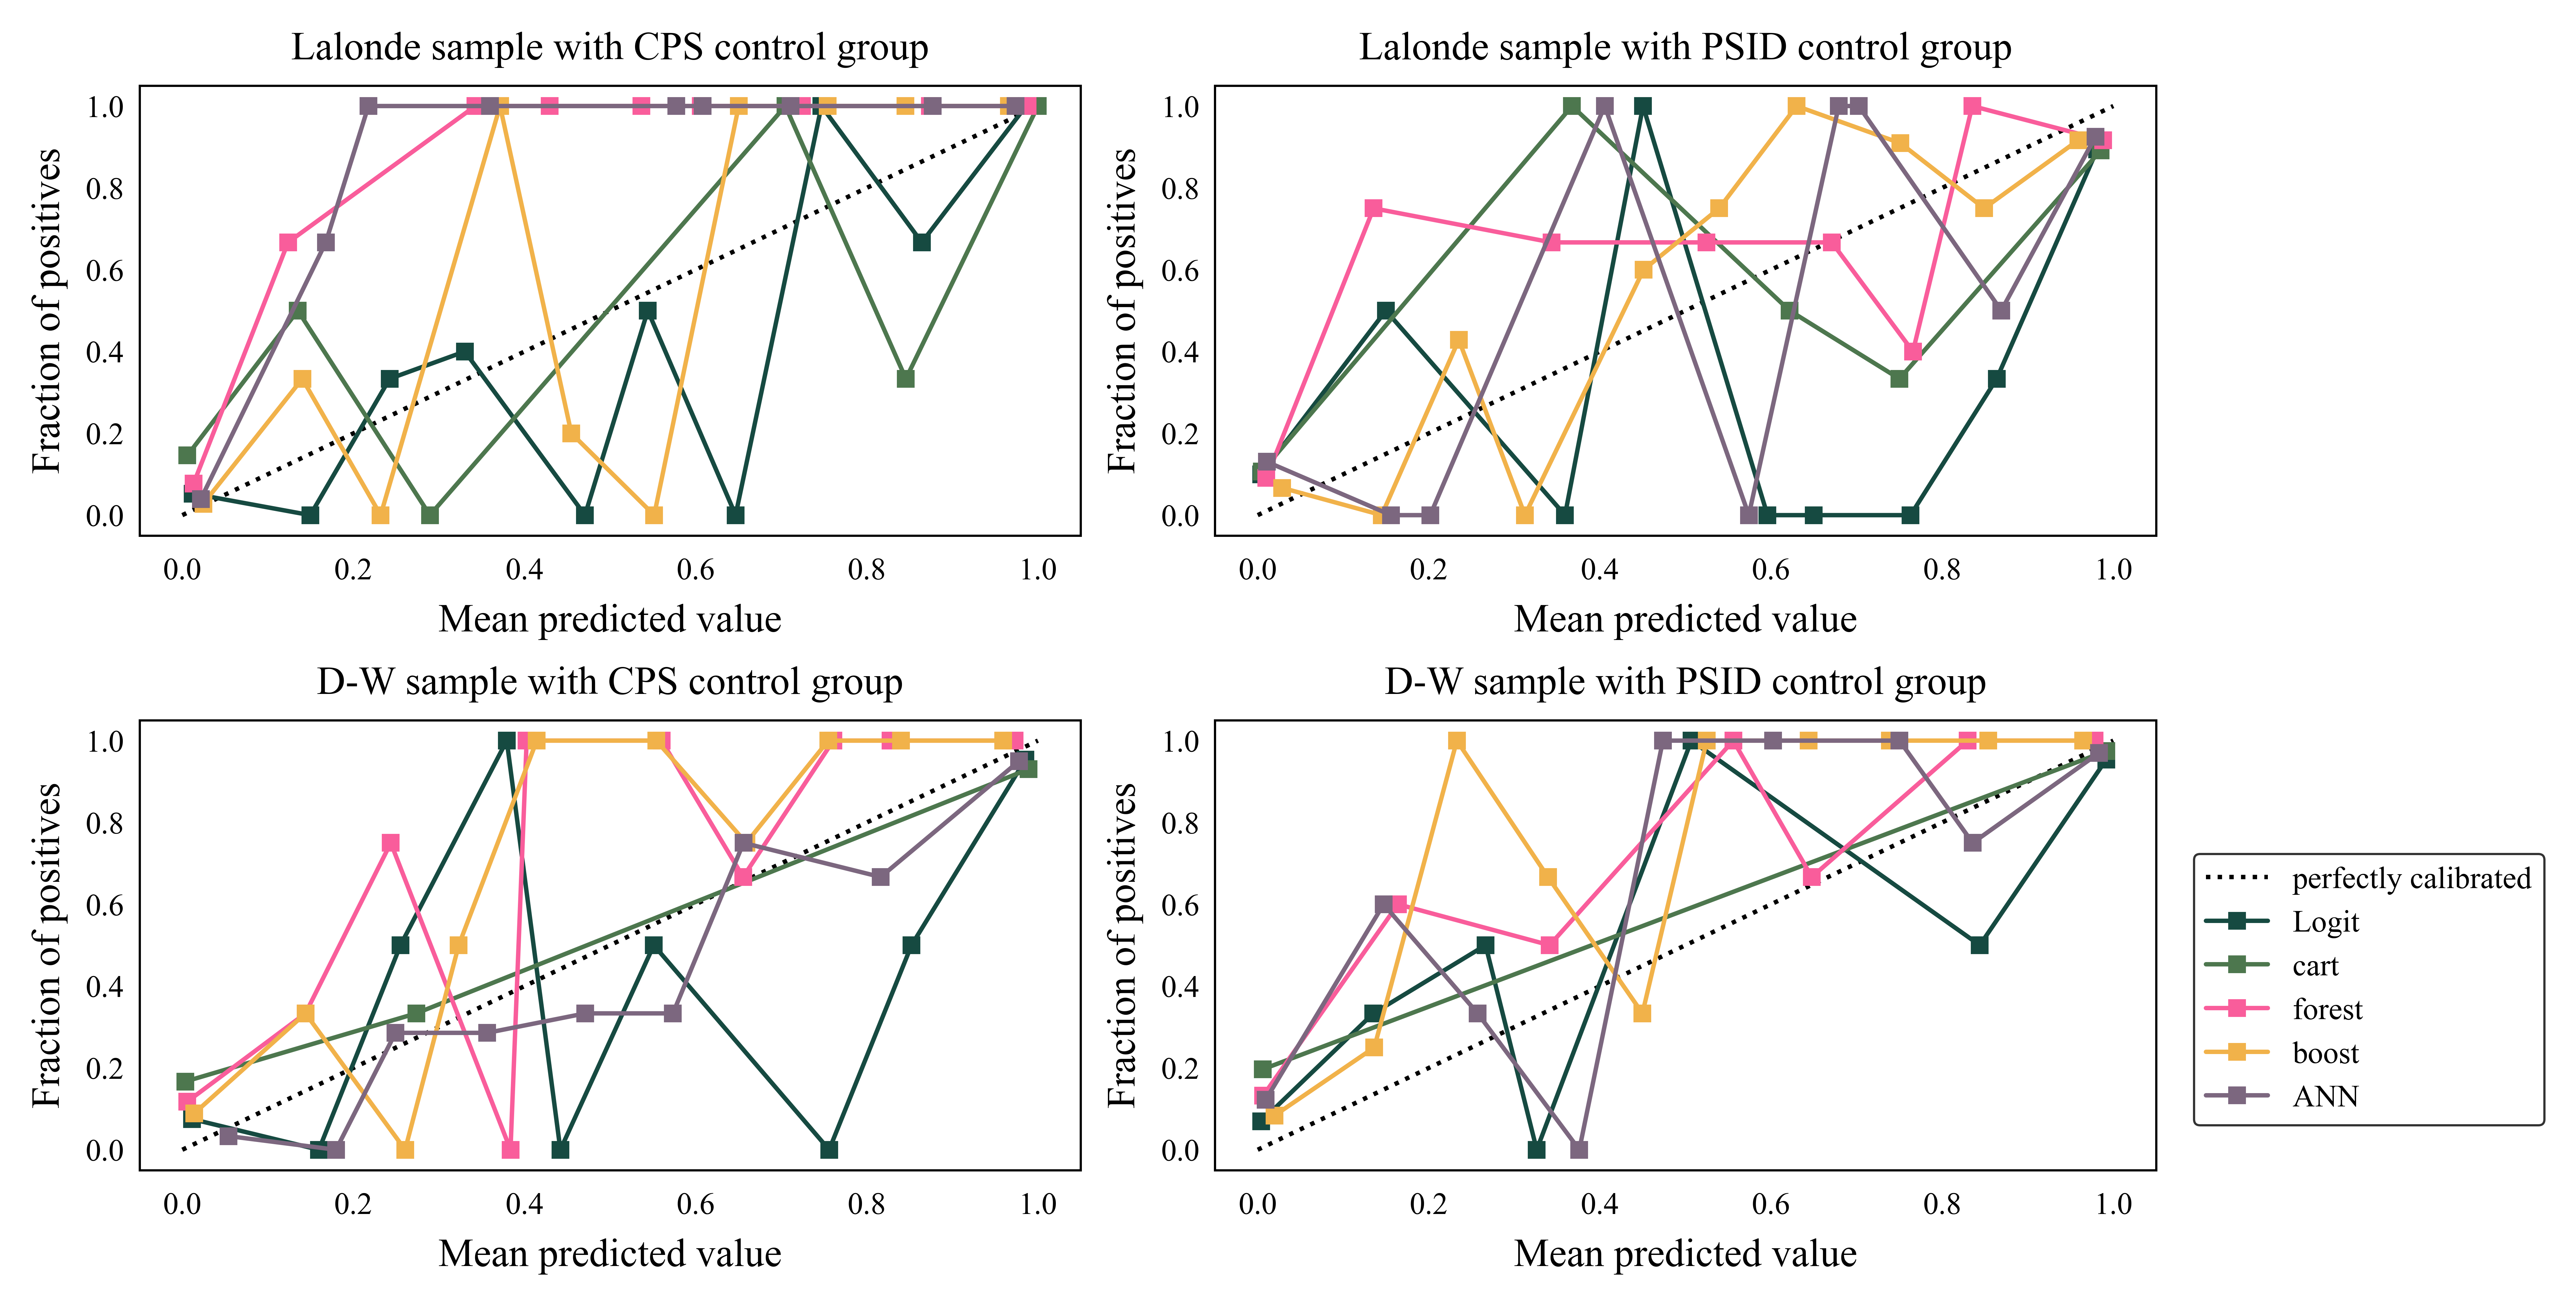

In [38]:
import scipy.stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (8,4))

plt.rcParams.update({"figure.dpi": 1000}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(axes.lines())


ax[0,0].grid(color='white', axis='x')
ax[0,0].grid(color='white', axis='y')
ax[0,1].grid(color='white', axis='x')
ax[0,1].grid(color='white', axis='y')
ax[1,0].grid(color='white', axis='x')
ax[1,0].grid(color='white', axis='y')
ax[1,1].grid(color='white', axis='x')
ax[1,1].grid(color='white', axis='y')

colour_1 = "#164A41"
colour_2 = "#4D774E"
colour_3 = "#f95d9b"
colour_4 = "#F1B24A"
colour_5 =   "#7c677f"

marker = 's'
linewidth = 1
marker_size = 3

ax[0,0].set_title('Lalonde sample with CPS control group')
ax[0,0].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[0,0].plot(logit_mpv1  , logit_fop1 , marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size, color = colour_1 )
ax[0,0].plot(cart_mpv1   , cart_fop1, marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size, color = colour_2 )
ax[0,0].plot(forest_mpv1 , forest_fop1,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size, color = colour_3 )
ax[0,0].plot(boost_mpv1  , boost_fop1,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size, color = colour_4 )
ax[0,0].plot(ann_mpv1    , ann_fop1 ,marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size, color = colour_5 )
ax[0,0].set_xlabel('Mean predicted value')
ax[0,0].set_ylabel('Fraction of positives')

ax[0,1].set_title('Lalonde sample with PSID control group')
ax[0,1].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[0,1].plot(logit_mpv2  , logit_fop2 , marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size, color = colour_1 )
ax[0,1].plot(cart_mpv2   , cart_fop2  , marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size, color = colour_2 )
ax[0,1].plot(forest_mpv2 , forest_fop2 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size, color = colour_3 )
ax[0,1].plot(boost_mpv2  , boost_fop2  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size, color = colour_4 )
ax[0,1].plot(ann_mpv2    , ann_fop2    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size, color = colour_5 )
ax[0,1].set_xlabel('Mean predicted value')
ax[0,1].set_ylabel('Fraction of positives')

ax[1,0].set_title('D-W sample with CPS control group')
ax[1,0].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[1,0].plot(logit_mpv3  , logit_fop3  ,marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size, color = colour_1 )
ax[1,0].plot(cart_mpv3   , cart_fop3   ,marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size, color = colour_2 )
ax[1,0].plot(forest_mpv3 , forest_fop3 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size, color = colour_3 )
ax[1,0].plot(boost_mpv3  , boost_fop3  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size, color = colour_4 )
ax[1,0].plot(ann_mpv3    , ann_fop3    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size, color = colour_5 )
ax[1,0].set_xlabel('Mean predicted value')
ax[1,0].set_ylabel('Fraction of positives')

ax[1,1].set_title('D-W sample with PSID control group')
ax[1,1].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=linewidth,color='black')
ax[1,1].plot(logit_mpv4  , logit_fop4  ,marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size, color = colour_1 )
ax[1,1].plot(cart_mpv4   , cart_fop4   ,marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size, color = colour_2 )
ax[1,1].plot(forest_mpv4 , forest_fop4 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size, color = colour_3 )
ax[1,1].plot(boost_mpv4  , boost_fop4  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size, color = colour_4 )
ax[1,1].plot(ann_mpv4    , ann_fop4    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size, color = colour_5 )
ax[1,1].set_xlabel('Mean predicted value')
ax[1,1].set_ylabel('Fraction of positives')
ax[1,1].set_ylabel('Fraction of positives')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/calibration_curve.png', bbox_inches='tight')

plt.legend(loc=(1.04, 0.1))
plt.show()

## Box plots